- **This code is a preparation for computing the CL-DRTO solution using a scenario-based stochastic programming approach and its implementation in the plant.**

Here, we code:
- Find the steady-state solution using JuMP and compare it with the original reference: *1988_Economic Analysis of Different Structures of Online Process Optimization Systems_C Loeblein*
- Run a step test with the dynamic model and compare OC model with integrator
- Optimize the dynamic model using an open loop DRTO paradigm (one shot)
- Use previously computed trajectories for obtaining the MPC models
- Test MPC's to track setpoints
- Test sensitivity of different parameters

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: July 2023

[1.Model: Two CSTR's in series with an intermediary feed](#sec1) <br>
[2.Steady-state optimization](#sec2) <br>
[3. Integrating dynamic model](#sec3) <br>
[4. Dynamic optimization test](#sec4) <br>
[5. Identifying LMPC models](#sec5) <br>
[6. Testing LMPC for setpoint tracking and disturbance rejection](#sec6) <br>
[7. Parameter sensitivity](#sec7) <br>
[8. Testing CL-DRTO](#sec8) <br>

In [1]:
using LinearAlgebra, JuMP, Ipopt, Plots, DifferentialEquations

<a id="sec1"></a>

# Two CSTR's in series with an intermediary feed

The exothermic and irreversible reaction $A \rightarrow B$  is taking place in both reactors. In an
undesired side-reaction $B \rightarrow C$ traces of by-product $C$ are produced <br>


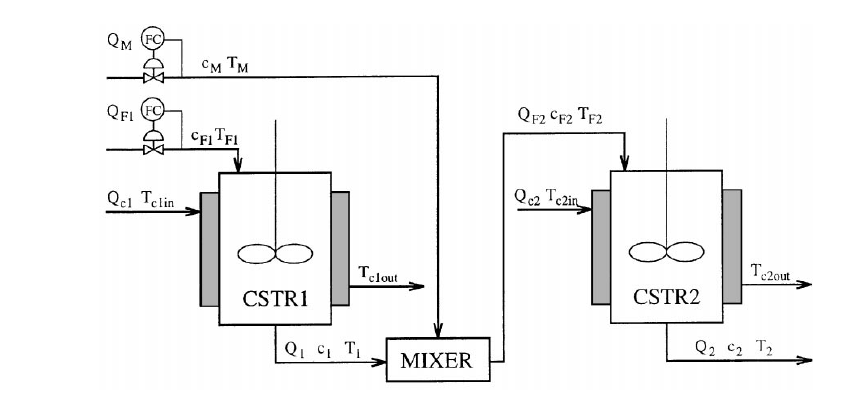

# System model

## Main assumptions
- Perfect level control in both reactors
- Mixer dynamics are instantaneous
- Adiabatic mixer
- Constant density $\rho$ and heat capacity $c_p$. Both are independent of the temperature, pressure, and mix composition
- Cooling jacket density $\rho$ and heat capacity $c_p$ are approximately the same as the $\rho$ and $c_p$ of the process fluid
- Reactions are first order, and described by Arrhenius Law
- Pure $A$ is fed to the first reactor and the mixer

## Model Equations

*CSTR 1* <br>

$\dfrac{d C_{A1}}{d t} = \dfrac{Q_1}{V_1} (C_{A1}^{in} - C_{A1}) - k_{I1}C_{A1} $ <br>
$\dfrac{d C_{B1}}{d t} = \dfrac{Q_1}{V_1} (C_{B1}^{in} - C_{B1}) + k_{I1}C_{A1} - k_{II1}C_{B1} $ <br>
$\dfrac{d C_{C1}}{d t} = \dfrac{Q_1}{V_1} (C_{C1}^{in} - C_{C1}) + k_{II1}C_{B1} $ <br>
$\dfrac{d T_1}{d t} = \dfrac{Q_1}{V_1} (T_{1}^{in} - T_{1}) - \dfrac{\Delta H_{RI}}{\rho \ c_p}k_{I1}C_{A1}  - \dfrac{\Delta H_{RII}}{\rho c_p}k_{II1}C_{B1} -  \dfrac{P_{c1}}{\rho \ c_p \ V} =  $ <br>
> $k_{I1} = k_{0I}\exp \bigg( \dfrac{E_I}{R \ T_1} \bigg)$ <br>
> $k_{II1} = k_{0II}\exp \bigg( \dfrac{E_I}{R \ T_1} \bigg)$ <br>
> $q_{cool,1} = \dfrac{P_{c1}}{\rho \ c_p} = \dfrac{UA_1}{\rho \ c_p} \Delta T_{ln1} = U_{a1}\dfrac{(T_{c1}^{out} - T_{c1}^{in})}{\ln [(T_{1} - T_{c1}^{in})/(T_{1} - T_{c1}^{out})]}$ <br>
> $q_{cool,1} = Q_{c1}(T_{c1}^{out} - T_{c1}^{in})$ <br>

*MIXER* <br>

> $0 = Q_1 + Q_M - Q_2$ <br>
> $0 = Q_1 \ C_{A1} + Q_M \ C_{AM} - Q_2 \ C_{A2}^{in}$ <br>
> $0 = Q_1 \ C_{B1} + Q_M \ C_{BM} - Q_2 \ C_{B2}^{in}$ <br>
> $0 = Q_1 \ C_{C1} + Q_M \ C_{CM} - Q_2 \ C_{C2}^{in}$ <br>
> $0 = Q_1 \ T_{1} + Q_M \ T_{M} - Q_2 \ T_{2}^{in}$ <br>


*CSTR 2* <br>

$\dfrac{d C_{A2}}{d t} = \dfrac{Q_2}{V_2} (C_{A2}^{in} - C_{A2}) - k_{I2}C_{A2} $ <br>
$\dfrac{d C_{B2}}{d t} = \dfrac{Q_2}{V_2} (C_{B2}^{in} - C_{B2}) + k_{I2}C_{A2} - k_{II2}C_{B2} $ <br>
$\dfrac{d C_{C2}}{d t} = \dfrac{Q_2}{V_2} (C_{C2}^{in} - C_{C2}) + k_{II2}C_{B2} $ <br>
$\dfrac{d T_2}{d t} = \dfrac{Q_2}{V_2} (T_{2}^{in} - T_{2}) - \dfrac{\Delta H_{R2}}{\rho \ c_p}k_{I2}C_{A2}  - \dfrac{\Delta H_{RII}}{\rho c_p}k_{II1}C_{B2} -  \dfrac{P_{c2}}{\rho \ c_p \ V} $ <br>
> $k_{I2} = k_{0I}\exp \bigg( \dfrac{E_I}{R \ T_2} \bigg)$ <br>
> $k_{II2} = k_{0II}\exp \bigg( \dfrac{E_I}{R \ T_2} \bigg)$ <br>
> $q_{cool,2} = \dfrac{P_{c2}}{\rho \ c_p} = \dfrac{UA_2}{\rho \ c_p} \Delta T_{ln2} = U_{a,2}\dfrac{(T_{c2}^{out} - T_{c2}^{in})}{\ln [(T_{2} - T_{c2}^{in})/(T_{2} - T_{c2}^{out})]}$ <br>
> $q_{cool,2} = Q_{c2}(T_{c2}^{out} - T_{c2}^{in})$ <br>

where, <br>
$t$: time \[s\] <br>
$C_{i \ r}$: concentration of substance $i = [A,B,C]$ in reactor $r = [1,2]$ \[kmol/m3\] <br>
$C_{i \ r}^{in}$: concentration of substance $i = [A,B,C]$ in feed to reactor $r = [1,2]$ \[kmol/m3\] <br>
$C_{i \ M}$: concentration of substance $i = [A,B,C]$ in feed to the mixer \[kmol/m3\] <br>
$T_{r}$: temperature in reactor $r = [1,2]$ \[K\] <br>
$T_{r}^{in}$: temperature of feed flow to reactor $r = [1,2]$ \[K\] <br>
$T_{r}^{in}$: temperature of feed flow to mixer \[K\] <br>
$T_{cr}^{in}$: inlet cooling water temperature to reactor $r = [1,2]$ \[K\] <br>
$T_{cr}^{out}$: outlet cooling water temperature to reactor $r = [1,2]$ \[K\] <br>
$Q_{r}$: volumetric flowrate to reactor $r = [1,2]$ \[m3/s\] <br>
$Q_{M}$: volumetric flowrate to mixer \[m3/s\] <br>
$Q_{cr}$: cooling water flow to reactor $r = [1,2]$ \[m3/s\] <br>
$q_{cool \ r}$: cooling rate of reactor $r = [1,2]$ \[m3 K/s\] <br>
$q_{cool \ r}$: cooling rate of reactor $r = [1,2]$ \[m3 K/s\] <br>
$V_r$: holdup in reactor $r = [1,2]$ \[m3\] <br>
$k_{0I}$: main reaction rate constant \[1/s\] <br>
$k_{0II}$: side-reaction rate constant \[1/s\] <br>
$E_{I}/R$: activation energy of main reaction \[K\] <br>
$E_{II}/R$: activation energy of side-reaction \[K\] <br>
$U_{a \ r}$: heat transfer coefficient in reactor $r = [1,2]$ \[m3/s\] <br>
$\Delta H_{I}/\rho \ c_p$: heat of main reaction \[m3 K/kmol\] <br>
$\Delta H_{II}/\rho \ c_p$: heat of side-reaction \[m3 K/kmol\] <br>

- System measurement ($y$) - $C_{A2}$, $C_{B2}$, $T_1$, $T_2$, $T_{c1}^{out}$, $T_{c2}^{out}$  <br>
- System inputs ($u$) - $Q_{1}$, $Q_{M}$ <br>
- System feed ($f$) - $C_{A1}^{in}$, $C_{B1}^{in}$, $C_{C1}^{in}$, $T_{1}^{in}$, $C_{AM}$, $C_{BM}$, $C_{CM}$, $T_{M}$,  $Q_{c1}$, $T_{c1}^{in}$, $Q_{c2}$, $T_{c2}^{in}$ <br>
- Parameters ($\theta$) - $V_{1}$, $V_{2}$, $U_{a1}$, $U_{a2}$, $k_{0I}$, $k_{0II}$, $E_{I}/R$, $E_{II}/R$, $\Delta H_{I}/ \rho c_p$, $\Delta H_{II} / \rho c_p$ <br>

## Model parameter values

In [2]:
# feed to reactor 1 concentrations c = (A,B,C)
C1_in = [20.0, 0, 0] #[kmol/m3]

# temperature of feed to reactor 1
T1_in = 300.0 #[K]

# feed to mixer concentration c = (A,B,C)
Cm_in = [20.0, 0, 0]

# temperature of feed to mixer
Tm_in = 300.0 #[K]

# feed flowrate of cooling water to reactor jacket r = (1,2)
Qj_in = [0.7, 0.7] #[m3/s]

# cooling water temperature to reactor jacket r = (1,2)
Tj_in = [300.0, 275.0] #[m3/s]

# reactor volumetric holdup r = (1,2)
V = [5.0, 5.0] #[m3]

# heat transfer coefficient
Ua = [0.35, 0.35] #[m3/s]

# reaction rate constant e = (I,II)
k0 = [2.7e8, 160.0] #[1/s]

# reaction activation energy e = (I,II)
ER = [6000.0, 4500.0] #[K]

# heat of reaction e = (I,II)
dH_pcp = -[5.0, 5.0] #[m3 K/kmol] 

# stochiometric matrix 
Ms = [-1 0;
       1 -1;
       0 1];

<a id="sec2"></a>

# Steady-state optimization

## Optimization parameters

In [3]:
# number of components
nc = 3 #[-]
# number of inputs
nu = 2 #[-]
# number of reactors
nrt = 2 #[-]
# number of reactions
nrc = 2 #[-]

# feed supply limitation
Qf_max = 0.8 #[m3/s] 

# safety restriction (avoiding temperature run away)
Tr_max = 350 #[K]

# product specifications
cA2_max = 0.3 #[kmol/m3]

# max cooling water outlet temperature r = (1,2)
Tj_max = [330, 300] #[K]

# min feed to reactor 1
Q_min = 0.05 #[m3/s]

# min feed to mixer
Qm_min = 0.05; #[m3/s]

In [4]:
# JuMP model
m_ss = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_ss, "print_level", 5)

# Set up variables
@variables(m_ss, begin
    C[1:nc, 1:nrt] ≥ 0           # [kmol/m3] concentration (diff states)
    T[rt=1:nrt] ≥ Tj_in[rt]      # [K] reactor temperature (diff states)
    C_in[1:nc, 1:nrt] ≥ 0        # [kmol/m3] inlet concentration (alg. states)
    T_in[rt=1:nrt] ≥ Tj_in[rt]   # [K] inlet temperature (alg. states)    
    Tj_out[rt=1:nrt] ≥ Tj_in[rt] # [K] jacket temperature (alg. states)    
    Q_min ≤ Q[1:nrt] ≤ Qf_max    # [m3/s] flowrate to reactor
    Qm_min ≤ Qm ≤ Qf_max         # [m3/s] flowrate to mixer
end)

# If using the rigorous model, we need to 
# initialize variables with approximate model solution (see commented equation for qcool)
#set_start_value(T[1], 350)
#set_start_value(T[2], 337)
#set_start_value(Tj_out[1], 320)
#set_start_value(Tj_out[2], 300)

@NLexpressions(m_ss, begin
    # [1/s] reaction rate
    k[rt = 1:nrt, rc = 1:nrc], k0[rc]*exp(-ER[rc]/T[rt])
    #[m3 K/s] cooling rate
    # rigorous model
    #qcool[rt = 1:nrt], Ua[rt]*(Tj_out[rt] - Tj_in[rt])/(log(T[rt] - Tj_in[rt]) - log(T[rt] - Tj_out[rt]))
    # approximate model *approximating logarithm temperature
    qcool[rt = 1:nrt], Ua[rt]*(T[rt] - (0.5*(Tj_out[rt] + Tj_in[rt])))
end)

#Set up the constraints
@NLconstraints(m_ss, begin
    #########
    # MODEL #
    #########    
    # reactor
    r_cmb[co = 1:nc, rt = 1:nrt], 0 == (C_in[co,rt] - C[co,rt])*Q[rt]/V[rt] + sum(Ms[co,rc]*k[rt,rc]*C[rc,rt] for rc in 1:nrc) 
    r_eb[rt = 1:nrt], 0 == (T_in[rt] - T[rt])*Q[rt]/V[rt] - sum(dH_pcp[rc]*k[rt,rc]*C[rc,rt] for rc in 1:nrc) - qcool[rt]/V[rt]
    # mixer
    m_mb, 0 == Q[1] + Qm - Q[2]
    m_cmb[co = 1:nc], 0 == Q[1]*C[co,1] + Qm*Cm_in[co] - Q[2]*C_in[co,2]
    m_eb, 0 == Q[1]*T[1] + Qm*Tm_in - Q[2]*T_in[2]
    # jacket
    j_eb[rt = 1:nrt], 0 == Qj_in[rt]*(Tj_out[rt] - Tj_in[rt]) - qcool[rt]
    ###############
    # CONSTRAINTS #
    ###############
    # safety restrictions
    g1[rt = 1:nrt], T[rt] - Tr_max ≤ 0
    # product specifications (Concentration of A in reactor 2)
    g2, C[1,2] - cA2_max ≤ 0
    # feed supply limitations
    g3, Q[1] + Qm - Qf_max ≤ 0
    # process limitations (others have been included when declaring variables): max cooling water outlet temperature
    g4[rt = 1:nrt], Tj_out[rt] - Tj_max[rt] ≤ 0
    ##############
    # PARAMETERS #
    ##############
    p1[co = 1:nc], C_in[co,1] - C1_in[co] == 0
    p2, T_in[1] - T1_in == 0
    end)

# Set up objective function  
@NLobjective(m_ss, Min, -(10*(Q[1]*C_in[1,1] + Qm*Cm_in[1] - Q[2]*(C[1,2] + C[3,2]))
                - 0.01*qcool[1] - qcool[2] - 0.1*Q[1] - 0.1*Qm));


In [5]:
# @show model_ms
optimize!(m_ss)
flag = termination_status(m_ss)

#calling values of the solved problem
o_star = objective_value(m_ss)

# "differential states"
C0_star = value.(C)
T0_star = value.(T)

# "algebraic states"
C_in0_star = value.(C_in)
T_in0_star = value.(T_in)
Tj_out0_star = value.(Tj_out)

# "inputs"
Q0_star = value.(Q)
Qm0_star = value.(Qm);

# checking if solution is the same as in the paper
#display(o_star)
#display(Q0[1])
#display(Qm0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       75
Number of nonzeros in inequality constraint Jacobian.:        7
Number of nonzeros in Lagrangian Hessian.............:      115

Total number of variables............................:       21
                     variables with only lower bounds:       18
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:       19
Total number of inequality co

In [6]:
# specifying MV values
# adding new constraints to the problem
@NLconstraints(m_ss, begin
    mv1, Q[1] - 0.2 == 0
    mv2, Qm - 0.2 == 0
    end)

# Set up new objective function (feasibility)  
@NLobjective(m_ss, Min, 0)

# solve problem again
optimize!(m_ss)

# initial value
C0 = value.(C)
T0 = value.(T)

# "algebraic states"
C_in0 = value.(C_in)
T_in0 = value.(T_in)
Tj_out0 = value.(Tj_out)

# "inputs"
Q0 = 0.2
Qm0 = 0.2;

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       77
Number of nonzeros in inequality constraint Jacobian.:        7
Number of nonzeros in Lagrangian Hessian.............:      106

Total number of variables............................:       21
                     variables with only lower bounds:       18
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:       21
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.00e+01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

<a id="sec3"></a>

# Integrating dynamic model

- integration starts from the optimal steady-state point computed above
- compare the results from DAE solver and Orthogonal Collocation in Finite elements

In [7]:
# Simulation time in sampling periods
nsim = 20

# Simulation sampling time
dt = 0.5 #[s]

# time series for plotting
t_sim = Vector{Float64}(undef,nsim) 
for ii in 1:nsim
    t_sim[ii] = dt*ii
end

# INITIAL CONDITION
# States (algebraic and differential): CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out
x0_star = [C0_star[1,1], C0_star[2,1], C0_star[3,1],T0_star[1],Tj_out0_star[1],C0_star[1,2], C0_star[2,2], C0_star[3,2],T0_star[2],Tj_out0_star[2]]

# Inputs: Q1,Qm --> step in the optimal solution
u0_integr = [Q0_star[1] + 0.1,Qm0_star];

## A) using DAE integrator

Preparing integrator

In [8]:
function twoCSTRS_dae!(dx, x, p, t)
    CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out = x
    Q1,Qm = p
    
    # reactor 1
    dx[1] = (C1_in[1] - CA1)*Q1/V[1] - k0[1]*exp(-ER[1]/T1)*CA1 
    dx[2] = (C1_in[2] - CB1)*Q1/V[1] + k0[1]*exp(-ER[1]/T1)*CA1 - k0[2]*exp(-ER[2]/T1)*CB1
    dx[3] = (C1_in[3] - CC1)*Q1/V[1] + k0[2]*exp(-ER[2]/T1)*CB1
    dx[4] = (T1_in - T1)*Q1/V[1] - dH_pcp[1]*k0[1]*exp(-ER[1]/T1)*CA1 - dH_pcp[2]*k0[2]*exp(-ER[2]/T1)*CB1 - Ua[1]*(T1 - (0.5*(Tj1_out + Tj_in[1])))/V[1]
    dx[5] = Qj_in[1]*(Tj1_out - Tj_in[1]) - Ua[1]*(T1 - (0.5*(Tj1_out + Tj_in[1])))
    # reactor 2
    dx[6] = ((Q1*CA1 + Qm*Cm_in[1])/(Q1 + Qm) - CA2)*(Q1 + Qm)/V[2] - k0[1]*exp(-ER[1]/T2)*CA2 
    dx[7] = ((Q1*CB1 + Qm*Cm_in[2])/(Q1 + Qm) - CB2)*(Q1 + Qm)/V[2] + k0[1]*exp(-ER[1]/T2)*CA2 - k0[2]*exp(-ER[2]/T2)*CB2 
    dx[8] = ((Q1*CC1 + Qm*Cm_in[3])/(Q1 + Qm) - CC2)*(Q1 + Qm)/V[2] + k0[2]*exp(-ER[2]/T2)*CB2 
    dx[9] = ((Q1*T1 + Qm*Tm_in)/(Q1 + Qm) - T2)*(Q1 + Qm)/V[2] - dH_pcp[1]*k0[1]*exp(-ER[1]/T2)*CA2 - dH_pcp[2]*k0[2]*exp(-ER[2]/T2)*CB2 - Ua[2]*(T2 - (0.5*(Tj2_out + Tj_in[2])))/V[2]
    dx[10] = Qj_in[2]*(Tj2_out - Tj_in[2]) - Ua[2]*(T2 - (0.5*(Tj2_out + Tj_in[2])))
    
    nothing
end

# mass matrix to determine algebraic equations
M = [1. 0 0 0 0 0 0 0 0 0;
     0 1. 0 0 0 0 0 0 0 0;
     0 0 1. 0 0 0 0 0 0 0;
     0 0 0 1. 0 0 0 0 0 0;
     0 0 0 0 0 0 0 0 0 0;
     0 0 0 0 0 1. 0 0 0 0;
     0 0 0 0 0 0 1. 0 0 0;
     0 0 0 0 0 0 0 1. 0 0;
     0 0 0 0 0 0 0 0 1. 0;
     0 0 0 0 0 0 0 0 0 0]

ode_fun_mm = ODEFunction(twoCSTRS_dae!,mass_matrix=M);

Simulating the system

In [9]:
# time series for plotting
Cr_integr = Array{Float64}(undef,nc,nrt,nsim) 
Tr_integr = Array{Float64}(undef,nrt,nsim)
Tj_integr = Array{Float64}(undef,nrt,nsim)

# preparing simulation (inputs are kept constant)
xk = x0_star

# Simulation time span
tspan = (0.0,dt)

for kk = 1:nsim
    
    ode_prob_mm = ODEProblem(ode_fun_mm,xk,tspan,u0_integr);
    sol =  solve(ode_prob_mm, Rodas5(),reltol=1e-8,abstol=1e-8,save_everystep = false);
    
    # saving data
    Cr_integr[:,1,kk] = sol.u[end][1:3]
    Tr_integr[1,kk] = sol.u[end][4]
    Tj_integr[1,kk] = sol.u[end][5]
    Cr_integr[:,2,kk] = sol.u[end][6:8]
    Tr_integr[2,kk] = sol.u[end][9]
    Tj_integr[2,kk] = sol.u[end][10]
    
    # loop
    xk = sol.u[end]
end 

## B) using orthogonal collocation

Preparing orthogonal collocation

In [10]:
# Parameters for orthogonal collocation
nfe    = nsim        # number of control intervals (finite elements)
ncp    = 3           # number of collocation points
th     = dt*nsim        # time horizon
h      = dt          # length of one finite element on the time horizon

# Collocation parameters and radau time series
colmat = [0.19681547722366  -0.06553542585020 0.02377097434822;
          0.39442431473909  0.29207341166523 -0.04154875212600;
          0.37640306270047  0.51248582618842 0.11111111111111]
radau  = [0.15505 0.64495 1.00000];

In [11]:
# JuMP model
m_dyn = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_dyn, "warm_start_init_point", "yes")
set_optimizer_attribute(m_dyn, "print_level", 5)

# Set up variables
@variables(m_dyn, begin
    C[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0           # [kmol/m3] concentration (diff states)
    Cdot[1:nc, 1:nrt, 1:nfe, 1:ncp]            # [kmol/m3/s] concentration (time derivative)
    T[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt]      # [K] reactor temperature (diff states)
    Tdot[rt=1:nrt, 1:nfe, 1:ncp]               # [K/s] reactor temperature (time derivative)
    C_in[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0        # [kmol/m3] inlet concentration (alg. states)
    T_in[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt]   # [K] inlet temperature (alg. states)    
    Tj_out[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt] # [K] jacket temperature (alg. states)    
    Q_min ≤ Q[1:nrt, 1:nfe] ≤ Qf_max    # [m3/s] flowrate to reactor
    Qm_min ≤ Qm[1:nfe] ≤ Qf_max         # [m3/s] flowrate to mixer
end)


# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for ii in 1:nfe
    for jj in 1:ncp
        for rr in 1:nrt
            for cc in 1:nc
                # concentration related variables
                set_start_value(C[cc,rr,ii,jj], C0_star[cc,rr]) 
                set_start_value(C[cc,rr,ii,jj], C0_star[cc,rr]) 
            end # components loop
            
            # temperature related variables
            set_start_value(T[rr,ii,jj], T0_star[rr]) 
            set_start_value(T_in[rr,ii,jj], T_in0_star[rr])
            set_start_value(Tj_out[rr,ii,jj], Tj_out0_star[rr])
            
        end # reactors loop
    end # collocation points loop

    # MV's
    for rr in 1:nrt
        set_start_value(Q[rr,ii], Q0_star[rr])  
    end
    set_start_value(Qm[ii], Qm0_star) 
end # finite elements loop

@NLexpressions(m_dyn, begin
    # [1/s] reaction rate
    k[rt = 1:nrt, rc = 1:nrc, ii = 1:nfe, jj = 1:ncp], k0[rc]*exp(-ER[rc]/T[rt,ii,jj])
    #[m3 K/s] cooling rate
    # approximate model *approximating logarithm temperature
    qcool[rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], Ua[rt]*(T[rt,ii,jj] - (0.5*(Tj_out[rt,ii,jj] + Tj_in[rt])))
end)

#Set up the constraints
@NLconstraints(m_dyn, begin
    #########
    # MODEL #
    #########    
    # reactor
    r_cmb[co = 1:nc, rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], Cdot[co,rt,ii,jj] == (C_in[co,rt,ii,jj] - C[co,rt,ii,jj])*Q[rt,ii]/V[rt] + sum(Ms[co,rc]*k[rt,rc,ii,jj]*C[rc,rt,ii,jj] for rc in 1:nrc) 
    r_eb[rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], Tdot[rt,ii,jj] == (T_in[rt,ii,jj] - T[rt,ii,jj])*Q[rt,ii]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,ii,jj]*C[rc,rt,ii,jj] for rc in 1:nrc) - qcool[rt,ii,jj]/V[rt]
    # mixer
    m_mb[ii = 1:nfe], 0 == Q[1,ii] + Qm[ii] - Q[2,ii]
    m_cmb[co = 1:nc,ii = 1:nfe,jj = 1:ncp], 0 == Q[1,ii]*C[co,1,ii,jj] + Qm[ii]*Cm_in[co] - Q[2,ii]*C_in[co,2,ii,jj]
    m_eb[ii = 1:nfe,jj = 1:ncp], 0 == Q[1,ii]*T[1,ii,jj] + Qm[ii]*Tm_in - Q[2,ii]*T_in[2,ii,jj]
    # jacket
    j_eb[rt = 1:nrt,ii = 1:nfe,jj = 1:ncp], 0 == Qj_in[rt]*(Tj_out[rt,ii,jj] - Tj_in[rt]) - qcool[rt,ii,jj]
    
    #########################    
    # Collocation Equations #    
    #########################
    # set up collocation equations - 2nd-to-nth point
    coll_C_n[co = 1:nc, rt = 1:nrt, ii = 2:nfe, jj = 1:ncp], C[co,rt,ii,jj] == C[co,rt,ii-1,ncp] + h*sum(colmat[jj,kk]*Cdot[co,rt,ii,kk] for kk in 1:ncp)    
    coll_T_n[rt = 1:nrt, ii = 2:nfe, jj = 1:ncp], T[rt,ii,jj] == T[rt,ii-1,ncp] + h*sum(colmat[jj,kk]*Tdot[rt,ii,kk] for kk in 1:ncp)
        
    # set up collocation equations - 1st point
    coll_C_0[co=1:nc, rt = 1:nrt, ii = [1], jj = 1:ncp], C[co,rt,ii,jj] == C0_star[co,rt] + h*sum(colmat[jj,kk]*Cdot[co,rt,ii,kk] for kk in 1:ncp)
    coll_T_0[rt = 1:nrt, ii = [1], jj = 1:ncp], T[rt,ii,jj] == T0_star[rt] + h*sum(colmat[jj,kk]*Tdot[rt,ii,kk] for kk in 1:ncp)
       
    ##############    
    # PARAMETERS #
    ##############
    # inputs are fixed here! Simulation
    mv1[ii = 1:nfe],  Q[1, ii] - u0_integr[1] == 0  
    mv2[ii = 1:nfe],  Qm[ii] - u0_integr[2] == 0
        
    p1[co = 1:nc,ii = 1:nfe,jj = 1:ncp], C_in[co,1,ii,jj] - C1_in[co] == 0
    p2[ii = 1:nfe,jj = 1:ncp], T_in[1,ii,jj] - T1_in == 0
    end)

# Set up objective function --> dummy for feasibility problem  
@NLobjective(m_dyn, Min, 0);


In [12]:
# Solve the model
status = optimize!(m_dyn)


# time series for plotting
Cr_oc = Array{Float64}(undef,nc,nrt,nfe) 
Tr_oc = Array{Float64}(undef,nrt,nfe)
Tj_oc = Array{Float64}(undef,nrt,nfe)

for rt in 1:nrt
    for co in 1:nc
        Cr_oc[co,rt,:] = value.(C[co,rt,:,3])
    end
    Tr_oc[rt,:] = value.(T[rt,:,3])
    Tj_oc[rt,:] = value.(Tj_out[rt,:,3])
end

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     7276
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6360

Total number of variables............................:     1620
                     variables with only lower bounds:     1080
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1620
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.00e+01 1.00e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Plotting (concentration, temperatures)

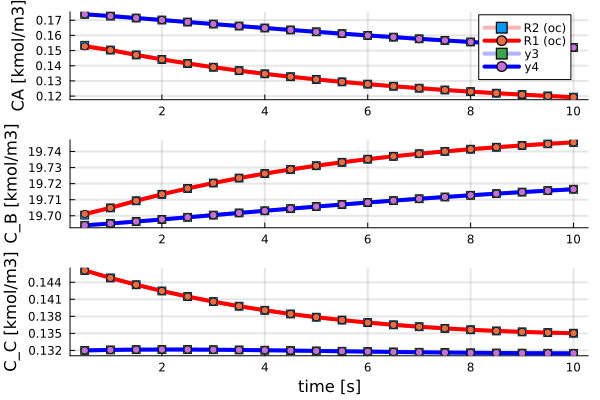

In [13]:
gr()

p1 = plot(t_sim,Cr_integr[1,1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="CA [kmol/m3]")
p1 = plot!(t_sim,Cr_oc[1,1,:],linewidth=4,linecolor = :red,marker=:circle)
p1 = plot!(t_sim,Cr_integr[1,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue)
p1 = plot!(t_sim,Cr_oc[1,2,:],linewidth=4,linecolor = :blue,marker=:circle)

p1.series_list[1][:label] = "R1 (dae)"
p1.series_list[2][:label] = "R1 (oc)"
p1.series_list[1][:label] = "R2 (dae)"
p1.series_list[1][:label] = "R2 (oc)"

p2 = plot(t_sim,Cr_integr[2,1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="C_B [kmol/m3]",legend=false)
p2 = plot!(t_sim,Cr_oc[2,1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p2 = plot!(t_sim,Cr_integr[2,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p2 = plot!(t_sim,Cr_oc[2,2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

p3 = plot(t_sim,Cr_integr[3,1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="C_C [kmol/m3]",legend=false)
p3 = plot!(t_sim,Cr_oc[3,1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p3 = plot!(t_sim,Cr_integr[3,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p3 = plot!(t_sim,Cr_oc[3,2,:],linewidth=4,linecolor = :blue,marker=:circle,xaxis="time [s]",legend=false)

g1 = plot(p1,p2,p3,layout=(3,1))
display(g1)


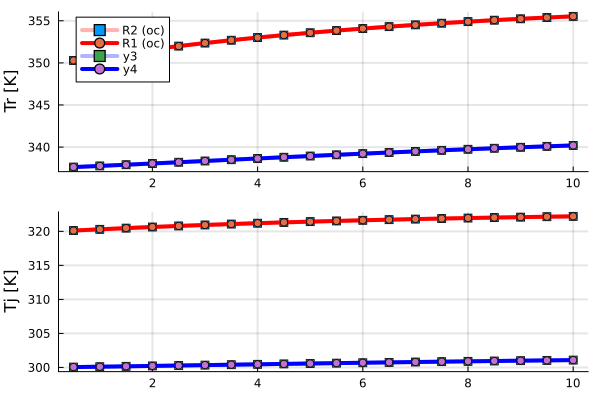

In [14]:
gr()

p4 = plot(t_sim,Tr_integr[1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Tr [K]")
p4 = plot!(t_sim,Tr_oc[1,:],linewidth=4,linecolor = :red,marker=:circle)
p4 = plot!(t_sim,Tr_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue)
p4 = plot!(t_sim,Tr_oc[2,:],linewidth=4,linecolor = :blue,marker=:circle)

p4.series_list[1][:label] = "R1 (dae)"
p4.series_list[2][:label] = "R1 (oc)"
p4.series_list[1][:label] = "R2 (dae)"
p4.series_list[1][:label] = "R2 (oc)"

p5 = plot(t_sim,Tj_integr[1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="Tj [K]",legend=false)
p5 = plot!(t_sim,Tj_oc[1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p5 = plot!(t_sim,Tj_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p5 = plot!(t_sim,Tj_oc[2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

g2 = plot(p4,p5,layout=(2,1))
display(g2)

<a id="sec4"></a>

# Optimizing Dynamic Model 

Finding an initial condition that is not the optimum
- Calling SS opt problem to find a feasible point for arbitrary values of the dof (previously found)

In [15]:
# JuMP model
m_drto = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_drto, "warm_start_init_point", "yes")
set_optimizer_attribute(m_drto, "print_level", 5)

# Set up variables
@variables(m_drto, begin
    C[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0           # [kmol/m3] concentration (diff states)
    Cdot[1:nc, 1:nrt, 1:nfe, 1:ncp]            # [kmol/m3/s] concentration (time derivative)
    T[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt]      # [K] reactor temperature (diff states)
    Tdot[rt=1:nrt, 1:nfe, 1:ncp]               # [K/s] reactor temperature (time derivative)
    C_in[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0        # [kmol/m3] inlet concentration (alg. states)
    T_in[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt]   # [K] inlet temperature (alg. states)    
    Tj_out[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt] # [K] jacket temperature (alg. states)    
    Q_min ≤ Q[1:nrt, 1:nfe] ≤ Qf_max    # [m3/s] flowrate to reactor
    Qm_min ≤ Qm[1:nfe] ≤ Qf_max         # [m3/s] flowrate to mixer
end)


# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for ii in 1:nfe
    for jj in 1:ncp
        for rr in 1:nrt
            for cc in 1:nc
                # concentration related variables
                set_start_value(C[cc,rr,ii,jj], C0_star[cc,rr]) 
                set_start_value(C[cc,rr,ii,jj], C0_star[cc,rr]) 
            end # components loop
            
            # temperature related variables
            set_start_value(T[rr,ii,jj], T0_star[rr]) 
            set_start_value(T_in[rr,ii,jj], T_in0_star[rr])
            set_start_value(Tj_out[rr,ii,jj], Tj_out0_star[rr])
            
        end # reactors loop
    end # collocation points loop

    # MV's
    for rr in 1:nrt
        set_start_value(Q[rr,ii], Q0_star[rr])  
    end
    set_start_value(Qm[ii], Qm0_star) 
end # finite elements loop

@NLexpressions(m_drto, begin
    # [1/s] reaction rate
    k[rt = 1:nrt, rc = 1:nrc, ii = 1:nfe, jj = 1:ncp], k0[rc]*exp(-ER[rc]/T[rt,ii,jj])
    #[m3 K/s] cooling rate
    # approximate model *approximating logarithm temperature
    qcool[rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], Ua[rt]*(T[rt,ii,jj] - (0.5*(Tj_out[rt,ii,jj] + Tj_in[rt])))
end)

#Set up the constraints
@NLconstraints(m_drto, begin
    #########
    # MODEL #
    #########    
    # reactor
    r_cmb[co = 1:nc, rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], Cdot[co,rt,ii,jj] == (C_in[co,rt,ii,jj] - C[co,rt,ii,jj])*Q[rt,ii]/V[rt] + sum(Ms[co,rc]*k[rt,rc,ii,jj]*C[rc,rt,ii,jj] for rc in 1:nrc) 
    r_eb[rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], Tdot[rt,ii,jj] == (T_in[rt,ii,jj] - T[rt,ii,jj])*Q[rt,ii]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,ii,jj]*C[rc,rt,ii,jj] for rc in 1:nrc) - qcool[rt,ii,jj]/V[rt]
    # mixer
    m_mb[ii = 1:nfe], 0 == Q[1,ii] + Qm[ii] - Q[2,ii]
    m_cmb[co = 1:nc,ii = 1:nfe,jj = 1:ncp], 0 == Q[1,ii]*C[co,1,ii,jj] + Qm[ii]*Cm_in[co] - Q[2,ii]*C_in[co,2,ii,jj]
    m_eb[ii = 1:nfe,jj = 1:ncp], 0 == Q[1,ii]*T[1,ii,jj] + Qm[ii]*Tm_in - Q[2,ii]*T_in[2,ii,jj]
    # jacket
    j_eb[rt = 1:nrt,ii = 1:nfe,jj = 1:ncp], 0 == Qj_in[rt]*(Tj_out[rt,ii,jj] - Tj_in[rt]) - qcool[rt,ii,jj]
    
    #########################    
    # Collocation Equations #    
    #########################
    # set up collocation equations - 2nd-to-nth point
    coll_C_n[co = 1:nc, rt = 1:nrt, ii = 2:nfe, jj = 1:ncp], C[co,rt,ii,jj] == C[co,rt,ii-1,ncp] + h*sum(colmat[jj,kk]*Cdot[co,rt,ii,kk] for kk in 1:ncp)    
    coll_T_n[rt = 1:nrt, ii = 2:nfe, jj = 1:ncp], T[rt,ii,jj] == T[rt,ii-1,ncp] + h*sum(colmat[jj,kk]*Tdot[rt,ii,kk] for kk in 1:ncp)
        
    # set up collocation equations - 1st point
    coll_C_0[co=1:nc, rt = 1:nrt, ii = [1], jj = 1:ncp], C[co,rt,ii,jj] == C0[co,rt] + h*sum(colmat[jj,kk]*Cdot[co,rt,ii,kk] for kk in 1:ncp)
    coll_T_0[rt = 1:nrt, ii = [1], jj = 1:ncp], T[rt,ii,jj] == T0[rt] + h*sum(colmat[jj,kk]*Tdot[rt,ii,kk] for kk in 1:ncp)
    
    ###############
    # CONSTRAINTS #
    ###############
    # ! Enforcing only at the end of the finite element
    # safety restrictions
    g1[rt = 1:nrt, ii = 1:nfe], T[rt,ii,ncp] - Tr_max ≤ 0
    # product specifications (Concentration of A in reactor 2)
    g2[ii = 1:nfe], C[1,2,ii,ncp] - cA2_max ≤ 0
    # feed supply limitations
    g3[ii = 1:nfe], Q[1,ii] + Qm[ii] - Qf_max ≤ 0
    # process limitations (others have been included when declaring variables): max cooling water outlet temperature
    g4[rt = 1:nrt, ii = 1:nfe], Tj_out[rt,ii,ncp] - Tj_max[rt] ≤ 0    
        
    ##############    
    # PARAMETERS #
    ##############
    p1[co = 1:nc,ii = 1:nfe,jj = 1:ncp], C_in[co,1,ii,jj] - C1_in[co] == 0
    p2[ii = 1:nfe,jj = 1:ncp], T_in[1,ii,jj] - T1_in == 0
    end)

# Set up objective function  
@NLobjective(m_drto, Min, -sum(h*(sum(
                                (
                                (10*(Q[1,ii]*C_in[1,1,ii,jj] + Qm[ii]*Cm_in[1] - Q[2,ii]*(C[1,2,ii,jj] + C[3,2,ii,jj])) - 0.01*qcool[1,ii,jj] - qcool[2,ii,jj] - 0.1*Q[1,ii] - 0.1*Qm[ii])
                                )*colmat[ncp,jj]
                                for jj in 1:ncp
                               )
                           ) for ii in 1:nfe
                        )
            )

In [16]:
# Solve the model
status = optimize!(m_drto)

# time series for plotting
Q_traj = value.(Q[1,:])
Qm_traj = value.(Qm)

Cr_traj = Array{Float64}(undef,nc,nrt,nfe) 
Tr_traj = Array{Float64}(undef,nrt,nfe)
Tj_traj = Array{Float64}(undef,nrt,nfe)

for rt in 1:nrt
    for co in 1:nc
        Cr_traj[co,rt,:] = value.(C[co,rt,:,3])
    end
    Tr_traj[rt,:] = value.(T[rt,:,3])
    Tj_traj[rt,:] = value.(Tj_out[rt,:,3])
end

# adding initial values
pushfirst!(Cr_traj, C0)
pushfirst!(Tr_traj, T0)
pushfirst!(Tj_traj, Tj_out0)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     7236
Number of nonzeros in inequality constraint Jacobian.:      140
Number of nonzeros in Lagrangian Hessian.............:     6820

Total number of variables............................:     1620
                     variables with only lower bounds:     1080
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1580
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.6116528e+02 2.00e+01 9.99e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

LoadError: MethodError: no method matching pushfirst!(::Array{Float64, 3}, ::Matrix{Float64})

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.

[0mClosest candidates are:
[0m  pushfirst!(::Any, ::Any, [91m::Any[39m) at abstractarray.jl:3061
[0m  pushfirst!(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at abstractarray.jl:3062
[0m  pushfirst!([91m::Vector{T}[39m, ::Any) where T at array.jl:1388
[0m  ...

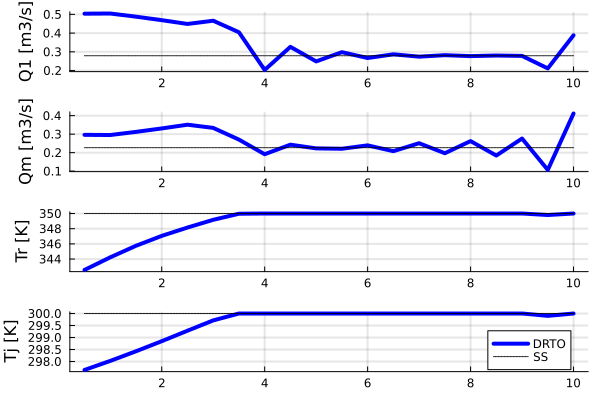

In [17]:
gr()

p6 = plot(t_sim,Q_traj,linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Q1 [m3/s]",legend=false)
p6 = plot!(t_sim,Q0_star[1].*ones(length(t_sim)),linestyle = :dot,linecolor = :black,legend=false)

p7 = plot(t_sim,Qm_traj,linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Qm [m3/s]",legend=false)
p7 = plot!(t_sim,Qm0_star.*ones(length(t_sim)),linestyle = :dot,linecolor = :black,legend=false)

p8 = plot(t_sim,Tr_traj[1,:],linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Tr [K]",legend=false)
p8 = plot!(t_sim,Tr_max.*ones(length(t_sim)),linestyle = :dot,linecolor = :black,legend=false)

p9 = plot(t_sim,Tj_traj[2,:],linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Tj [K]")
p9 = plot!(t_sim,Tj_max[2].*ones(length(t_sim)),linestyle = :dot,linecolor = :black)
p9.series_list[1][:label] = "DRTO"
p9.series_list[2][:label] = "SS"

g3 = plot(p6,p7,p8,p9,layout=(4,1))
display(g3)

<a id="sec5"></a>

# Obtaining MPC models

- The levels in both CSTRs are also assumed to be perfectly controlled (see modeling assumption). No controllers need to be modeled here
- (FROM HAO LI'S PAPER) The temperature (T1 and T2) for each CSTR serves as the output for its assigned MPC. The inlet flow rate to the first CSTR serves as the input for the first NMPC and the flow rate of fresh feed to the mixer for the other NMPC.

## Step response trajectories from nonlinear model

In [18]:
# step test simulation length
nstep = 150

# Simulation time span
tspan = (0.0,dt)

# time series for plotting
t_step = Vector{Float64}(undef,nstep) 
for ii in 1:nstep
    t_step[ii] = dt*ii
end

- T1 as a function of Q1

In [19]:
# time series for plotting
Tr_T1 = Vector{Float64}(undef,nstep)
# Inputs: Q1,Qm --> step in the optimal solution 10%
Q1_step = Matrix{Float64}(undef,2,nstep) 
for kk in 1:nstep
    if kk < 10
        Q1_step[1,kk] = Q0_star[1]
    else
        Q1_step[1,kk] = Q0_star[1]  + 0.1*Q0_star[1]
    end

    Q1_step[2,kk] = Qm0_star
        
end

# preparing simulation (starting from opt steady-state)
xk = x0_star

for kk = 1:nstep
    
    ode_prob_mm = ODEProblem(ode_fun_mm,xk,tspan,Q1_step[:,kk]);
    sol =  solve(ode_prob_mm, Rodas5(),reltol=1e-8,abstol=1e-8,save_everystep = false);
    
    # saving data
    Tr_T1[kk] = sol.u[end][4]
    
    # loop
    xk = sol.u[end]
end 

In [20]:
# time series for plotting
Tr_T2 = Vector{Float64}(undef,nstep)
# Inputs: Q1,Qm --> step in the optimal solution 10%
Qm_step = Matrix{Float64}(undef,2,nstep) 

# preparing simulation (starting from opt steady-state)
xk = x0_star

for kk in 1:nstep
    if kk < 10
        Qm_step[2,kk] = Qm0_star
    else
        Qm_step[2,kk] = Qm0_star  + 0.1*Qm0_star
    end

    Qm_step[1,kk] = Q0_star[1]
        
end

# Simulation time span
tspan = (0.0,dt)

for kk = 1:nstep
    
    ode_prob_mm = ODEProblem(ode_fun_mm,xk,tspan,Qm_step[:,kk]);
    sol =  solve(ode_prob_mm, Rodas5(),reltol=1e-8,abstol=1e-8,save_everystep = false);
    
    # saving data
    Tr_T2[kk] = sol.u[end][9]
    
    # loop
    xk = sol.u[end]
end 

- T2 as a function of Qm

## Estimating linear models from step response

In [21]:
# reference for deviation variables
T1_0_bar = x0_star[4]
Q1_0_bar = Q0_star[1]

mpc_id1 = Model(Ipopt.Optimizer) 
set_silent(mpc_id1) 
@variable(mpc_id1, T1_bar_hat[1:nstep]) # estimated reponse
# SISO model: x_{k+1} = A x_{k} + B u_{k}
@variable(mpc_id1, a1) # A matrix
@variable(mpc_id1, b1) # B matrix

# model 
@constraint(mpc_id1,m_1,T1_bar_hat[1] == a1*0 + b1*(Q1_step[1,1] - Q1_0_bar))
@constraint(mpc_id1,m_k[kk = 2:nstep], T1_bar_hat[kk] == a1*T1_bar_hat[kk - 1] + b1*(Q1_step[1,kk] - Q1_0_bar))

@NLobjective(mpc_id1, Min, sum(((Tr_T1[kk] - T1_0_bar) - T1_bar_hat[kk])^2 for kk in 1:nstep)) 
optimize!(mpc_id1);

a1_hat = value(a1)
b1_hat = value(b1)

#display(a1_hat)
#display(b1_hat)

# computing estimated model response
# time series for plotting
Tr_T1_hat = Vector{Float64}(undef,nstep)

# preparing simulation (starting from opt steady-state): variables in deviation form
Tr1_hat_k = x0_star[4] - T1_0_bar

for kk = 1:nstep
    Tr1_hat_k= a1_hat*Tr1_hat_k + b1_hat*(Q1_step[1,kk] - Q1_0_bar)
    
    # saving data
    Tr_T1_hat[kk] = Tr1_hat_k + T1_0_bar
end 

In [22]:
# reference for deviation variables
T2_0_bar = x0_star[9]
Qm_0_bar = Qm0_star

mpc_id2 = Model(Ipopt.Optimizer) 
set_silent(mpc_id2)

@variable(mpc_id2, T2_bar_hat[1:nstep]) # estimated reponse
# SISO model: x_{k+1} = A x_{k} + B u_{k}
@variable(mpc_id2, a2) # A matrix
@variable(mpc_id2, b2) # B matrix

# model 
@constraint(mpc_id2,m_1,T2_bar_hat[1] == a2*0 + b2*(Qm_step[2,1] - Qm_0_bar))
@constraint(mpc_id2,m_k[kk = 2:nstep], T2_bar_hat[kk] == a2*T2_bar_hat[kk - 1] + b2*(Qm_step[2,kk] - Qm_0_bar))

@NLobjective(mpc_id2, Min, sum(((Tr_T2[kk] - T2_0_bar) - T2_bar_hat[kk])^2 for kk in 1:nstep)) 
optimize!(mpc_id2);

a2_hat = value(a2)
b2_hat = value(b2)

#display(a2_hat)
#display(b2_hat)

# computing estimated model response
# time series for plotting
Tr_T2_hat = Vector{Float64}(undef,nstep)

# preparing simulation (starting from opt steady-state): variables in deviation form
Tr2_hat_k = x0_star[9] - T2_0_bar

for kk = 1:nstep
    Tr2_hat_k= a2_hat*Tr2_hat_k + b2_hat*(Qm_step[2,kk] - Qm_0_bar)
    
    # saving data
    Tr_T2_hat[kk] = Tr2_hat_k + T2_0_bar
end 

## Plotting response vs. linear model

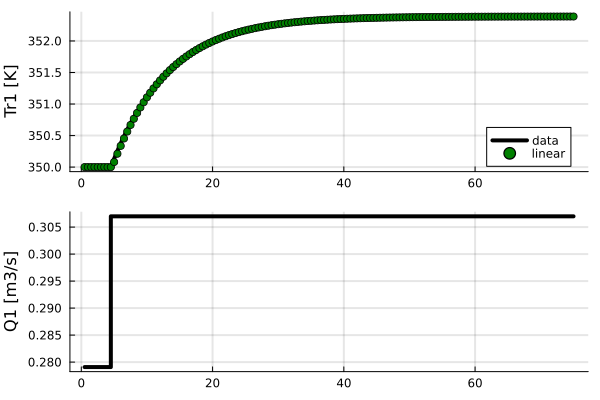

In [23]:
gr()

p10 = plot(t_step,Tr_T1_hat,linewidth=4,linecolor=:black,gridlinewidth=2,yaxis="Tr1 [K]")
p10 = scatter!(t_step,Tr_T1,marker = :circle,markercolor=:green)

p10.series_list[1][:label] = "data"
p10.series_list[2][:label] = "linear"

p11 = plot(t_step,Q1_step[1,:],linetype=:steppre,linewidth=4,linecolor = :black,gridlinewidth=2,yaxis="Q1 [m3/s]",legend=false)

g4 = plot(p10,p11,layout=(2,1))
display(g4)

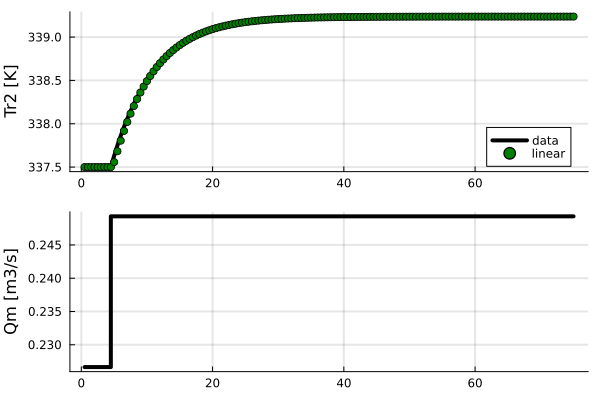

In [24]:
gr()

p12 = plot(t_step,Tr_T2_hat,linewidth=4,linecolor=:black,gridlinewidth=2,yaxis="Tr2 [K]")
p12 = scatter!(t_step,Tr_T2,marker = :circle,markercolor=:green)
p12.series_list[1][:label] = "data"
p12.series_list[2][:label] = "linear"

p13 = plot(t_step,Qm_step[2,:],linetype=:steppre,linewidth=4,linecolor = :black,gridlinewidth=2,yaxis="Qm [m3/s]",legend=false)

g5 = plot(p12,p13,layout=(2,1))
display(g5)

<a id="sec6"></a>

# Testing MPC's for setpoint tracking and disturbance rejection

$$ min_{u_k} J_k = \sum_{j=1}^p (y(k + j|k) - y^{SP})^T \ Q \ (y(k + j|k) - y^{SP}) + \sum_{j=1}^{m-1} \Delta u(k + j|k)^T \ R \ \Delta u(k + j|k) $$

$$ s.t.: x(k+1) = A_d \ x(k) + B_d \ u(k) $$
$$ y(k) = C_d \ x(k)$$ 
$$ u_{min} \leq u_k \leq u_{max}  \quad k = 1,\ldots,m $$

where $p$ is the output prediction horizon; $m$ is the input horizon; $y^{sp}$ is the desired value of the output; $Q$ and $R$ are weighting matrices of appropriate di-
mensions.

Tuning parameters from paper: *2018, Economic Coordination of Distributed Nonlinear MPC Systems using Closed-loop Prediction of a Nonlinear Dynamic Plant, H Li and C L E Swartz*

In [25]:
# prediction horizon 
p = 5

# control horizon 
m = 3

# output tracking weight
q = 1

# move supression weight
r = [150,500]

# input bounds
u_mpc_lb = 0.050
u_mpc_ub = 0.805;

Building MPC matrices based on the plant model and the tuning parameters

**1. Adding disturbance model**

The closed-loop system may never reach the desired controlled variable target if an unmeasured, constant disturbance
enters the process or if model error is present. This problem can be solved by incorporating a constant output disturbance
into the process model: 

$
\begin{vmatrix}
x(k + 1)\\
d(k + 2)
\end{vmatrix}
= 
\begin{vmatrix}
A & 0_{nx,ny}\\
0_{ny,nx} & I_{ny}\\
\end{vmatrix} \ x(k)
\begin{vmatrix}
x(k)\\
d(k)
\end{vmatrix}
+
\begin{vmatrix}
B\\
0_{ny,nu}\end{vmatrix} 
u(k)
$

$
y(k)
= 
\begin{vmatrix}
C & G_p
\end{vmatrix} 
\begin{vmatrix}
x(k)\\
d(k)
\end{vmatrix}
$

in which $d \in \mathcal{R}^{ny}$ is the number of augmented output disturbance states, and $G_p$ determines the effect of these states on the output. In the standard industrial model predictive control implementation, $G_p=I$ and the output
disturbance is estimated as $d_k = y_k - C x_k$.

Abusing notation and refering to the extended state ($[x, d]$) as $x$ and denoting the extended matrices above with the subscript $d$, we have the following discrete state-space model:

$ x(k+1) = A_d \ x(k) + B_d \ u(k) $ <br>
$ y(k) = C_d \ x(k)$ <br>


**2. Building system dynamics matrix for rearranging MPC problem**

Using the supperposition property of linear systems, we obtain the model outputs from instants $k+1$ to $k+j$ as: <br>
$ y(k + 1|k) = C_d \ x(k + 1|k) = C_dA_d \ x(k) + C_dB_d \ u(k|k)$ <br>
$ y(k + 2|k) = C_dA_d^2 \ x(k) + C_dA_dB_d \ u(k|k) + C_dB_d \ u(k+1|k)$ <br>
$ y(k + 3|k) = C_dA_d^3 \ x(k) + C_dA_d^2B_d \ u(k|k) + C_dA_dB_d \ u(k+1|k) + C_dB_d \ u(k+2|k)$ <br>
$ ... $ <br>
$ y(k + j|k) = C_dA_d^j \ x(k) + C_dA_d^{j-1}B_d \ u(k|k) + C_dA_d^{j-2}B_d \ u(k+1|k) + \cdots + C_dB_d \ u(k + j -1|k)$ 

Suppose now that:<br>
$ u(k + m|k) = u(k + m + 1|k) = \cdots = u(k + p - 1|k)$

The equations above (when $j > m$) can then be re-written as:
$ y(k + m + 1|k) = C_dA_d^{m+1} \ x(k) + C_dA_d^{m}B_d \ u(k|k) + C_dA_d^{m-1}B_d \ u(k+1|k) + \cdots + [C_dA_dB_d + C_dB_d] \ u(k + m -1|k)$ <br>
$ y(k + m + 2|k) = C_dA_d^{m+2} \ x(k) + C_dA_d^{m+1}B_d \ u(k|k) + C_dA_d^{m}B_d \ u(k+1|k) + \cdots + [C_dA_d^2B_d + C_dA_dB_d + C_dB_d] \ u(k + m -1|k)$ <br>
$ ... $ <br>
$ y(k + pk) = C_dA_d^{p} \ x(k) + C_dA_d^{p-1}B_d \ u(k|k) + C_dA_d^{p-2}B_d \ u(k+1|k) + \cdots + [C_dA_d^{p-m}B_d + C_dA_d^{p-m-1}B_d + \cdots + C_dB_d] \ u(k + m -1|k)$

Thus, the vector of output predictions can be written as follows:

$
\begin{vmatrix}
y(k + 1|k)\\
y(k + 2|k)\\
\vdots \\
y(k + m|k) \\
y(k + m + 1|k)\\ 
\vdots \\
y(k + p|k)
\end{vmatrix}
= 
\begin{vmatrix}
C_dA_d\\
C_dA_d^{2}\\
\vdots \\
C_dA_d^{m} \\
C_dA_d^{m+1}\\ 
\vdots \\
C_dA_d^{p}
\end{vmatrix} \ x(k)
+
\begin{vmatrix}
C_dB_d          & 0               & \cdots & 0\\
C_dA_dB_d       & C_dB_d          & \cdots & 0\\
\vdots          & \vdots          & \cdots & \vdots\\
C_dA_d^{m-1}B_d & C_dA_d^{m-2}B_d & \cdots & C_dB_d\\
C_dA_d^{m}B_d   & C_dA_d^{m-1}B_d & \cdots & C_d\tilde{A}_{d,1}B_d\\ 
\vdots          & \vdots          & \cdots & \vdots\\
C_dA_d^{p-1}B_d & C_dA_d^{p-2}B_d & \cdots & C_d\tilde{A}_{d,p-m}B_d
\end{vmatrix} 
\begin{vmatrix}
u(k|k)\\
u(k + 2|k)\\
\vdots \\
u(k + m - 1|k) 
\end{vmatrix}
$

where: <br>
$\tilde{A}_{d,1} = A_d + I, \quad \tilde{A}_{d,2} = A_d^2 + A_d + I, \quad \tilde{A}_{d,p-m} = A_d^{p-m} + A_d^{p-m-1} + \cdots + I$

Simpifying, we have: <br>
$ \bar{y}(k) = \Psi \ x(k) + \Theta \ u(k) $ 

**3. Rearranging optimization problem**

The first term (output tracking) of the MPC objective function is: 

$ \sum_{j=1}^p (y(k + j|k) - y^{SP})^T \ Q \ (y(k + j|k) - y^{SP}) $

which can be written as:

$ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) $

where: 
$ \bar{Q} = diag\bigg( Q, \cdots, Q\bigg)$ - $p$ repetitions of $Q$

The second term (inputs movement penalization) of the MPC objective function is: 

$ \sum_{j=1}^{m-1} \Delta u(k + j|k)^T \ R \ \Delta u(k + j|k) $

We observe that:
$
\begin{vmatrix}
\Delta u(k|k)\\
\Delta u(k + 1|k)\\
\vdots \\
\Delta u(k + m - 1|k) 
\end{vmatrix}
= 
\begin{vmatrix}
u(k|k) - u(k - 1)\\
u(k + 1|k) - u(k|k)\\
\vdots \\
u(k + m - 1|k) - u(k + m - 2|k)
\end{vmatrix}
=
u_k - Mu_k - \bar{I} u(k - 1)
= (I_{nu,m} - M)u_k - \bar{I} u(k - 1)
= I_M u_k - \bar{I} u(k - 1)
$

in which:
$
M = 
\begin{vmatrix}
0_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
I_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
0_{nu} & I_{nu} & \cdots & 0_{nu} & 0_{nu}\\
\vdots & \vdots & \cdots & \vdots & \vdots\\
0_{nu} & 0_{nu} & \cdots & I_{nu} & 0_{nu}
\end{vmatrix}, \quad
\bar{I} = 
\begin{vmatrix}
I_{nu}\\
0_{nu}\\
0_{nu}\\
\vdots\\
0_{nu}
\end{vmatrix}
$

the second term can be written as:

$ (I_M u_k - \bar{I} u(k - 1))^T \ \bar{R} \ (I_M u_k - \bar{I} u(k - 1)) $

where: 
$ \bar{R} = diag\bigg( R, \cdots, R\bigg)$ - $m$ repetitions of $R$

The objective function then can be reduced to a quadratic function of the form:
$$ J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

where:

$H = \Theta^T \ \bar{Q} \ \Theta + I_M^T \ \bar{R} \ I_M$ <br>
$c_f^T = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ \Theta + u(k-1)^T\bar{I}^T \ \bar{R} \ I_M$ <br>
$c = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) + u(k-1)^T\bar{I}^T \ \bar{R} \ \bar{I} \ u(k-1)$

In [26]:
function MPC_matrices(A,B,C,p,m,q,r)
    ###########
    # inputs: #
    ###########
    # A,B,C - System model
    # p, m - prediction and control horizon
    # q, r - setpoint and input usage tuning parameters
    
    # extracting dimensions from system model
    nx = size(A,1) # states
    nu = size(B,2) # inputs
    ny = size(C,1) # outputs
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

Creating function that solves MPC problem

- After rearranging the system, the MPC matrices become:

$$ min_{u_k} J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

$$ s.t.: u_{min} \leq u_k \leq u_{max}  \quad k = 1,\ldots,m $$ 

In [27]:
function solveMPC(xkk,dekk,uk_1,yspk,umin,umax,yref,uref,mpc,p,m)
    ###########
    # inputs: #
    ###########
    # xkk - current states (MPC model) 
    # dekk - disturbance estimate 
    # uk_1 - inputs at the current iteration, already implemented on the plant
    # yspk - setpoint trajectory computed by CL-DRTO
    # umin, umax - input bounds
    # yref, uref - reference points for computing deviation variables
    # mpcModel - System model
    # p, m - prediction and control horizon
    
    MPC_con = Model(Ipopt.Optimizer)
    set_silent(MPC_con)
    
    ####################
    # Set up variables #
    ####################
    # inputs computed by MPCs
    @variable(MPC_con, (umin - uref) ≤ u[1:m] ≤ (umax - uref) )
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # for OF computation
    @expression(MPC_con, cfT, (mpc['Ψ']*[xkk;dekk] - (yspk - yref)*ones(p,1))'*mpc['Q']*mpc['Θ'] - (uk_1 - uref)'*mpc['I']'*mpc['R']*mpc['M'])
        
    #############################
    # Set up objective function #
    #############################
    @objective(MPC_con, Min, sum(u[jj]*sum(mpc['H'][jj,ii]*u[ii] for ii in 1:m) for jj in 1:m) + 2*sum(cfT[jj]*u[jj] for jj = 1:m))
    # @show MPC_con

    #################
    # Solve Problem #
    #################
    optimize!(MPC_con)

    #calling values of the solved problem
    ϕ = objective_value(MPC_con)
    uArray = value.(u) .+ uref

    return Dict('ϕ' => ϕ,'u' => uArray)
end;

## Simulation for testing MPC performance

In [28]:
# MPC test simulation length
nmpc = 300

# Integration step 
tspan = (0.0,dt)

# time series for plotting
t_mpc = Vector{Float64}(undef,nmpc) 
for kk in 1:nmpc
    t_mpc[kk] = dt*kk
end

# Control Setpoint
T_sp = Matrix{Float64}(undef,2,nmpc) 
for kk in 1:nmpc
    if kk < 150  
        T_sp[1,kk] = T0[1]
    else
        T_sp[1,kk] = T0[1] - 0.05*T0[1]
    end
    
    if kk > 100 && kk < 200
        T_sp[2,kk] = T0[2] - 0.05*T0[2]
    else
        T_sp[2,kk] = T0[2] 
    end
end

# time series for plotting
Tr = Matrix{Float64}(undef,2,nmpc)
Qmpc = Matrix{Float64}(undef,2,nmpc)

# building MPC's
# reactor 1 MPC: T1 <-> Q1
mpc1 = MPC_matrices(a1_hat,b1_hat,1,p,m,q,r[1])
# reactor 2 MPC: T2 <-> Qm
mpc2 = MPC_matrices(a2_hat,b2_hat,1,p,m,q,r[2])

# preparing simulation (starting from opt steady-state)
# plant 
xk = x0_star
uk = [Q0_star[1] Qm0_star];

# mpc's models - initial states is the same
xk_mpc1 = x0_star[4] - T1_0_bar
dek_mpc1 = 0.0
xk_mpc2 = x0_star[9] - T2_0_bar
dek_mpc2 = 0.0

for kk = 1:nmpc
    display("MPC test: Iteration $(kk)")

    # solving MPC

    sol1 = solveMPC(xk_mpc1,dek_mpc1,uk[1],T_sp[1,kk],u_mpc_lb,u_mpc_ub,T1_0_bar,Q1_0_bar,mpc1,p,q)
    sol2 = solveMPC(xk_mpc2,dek_mpc2,uk[2],T_sp[2,kk],u_mpc_lb,u_mpc_ub,T2_0_bar,Qm_0_bar,mpc2,p,q)
    
    # evolving plant
    ode_prob_mm = ODEProblem(ode_fun_mm,xk,tspan,[sol1['u'][1],sol2['u'][1]]);
    sol =  solve(ode_prob_mm, Rodas5(),reltol=1e-8,abstol=1e-8,save_everystep = false);
    
    # evolving MPC models
    xk_mpc1  = a1_hat*xk_mpc1 + b1_hat*(sol1['u'][1] - Q1_0_bar)
    dek_mpc1 = sol.u[end][4] - (xk_mpc1 + T1_0_bar)
    
    xk_mpc2  = a2_hat*xk_mpc2 + b2_hat*(sol2['u'][1] - Qm_0_bar)
    dek_mpc2 = sol.u[end][9] - (xk_mpc2 + T2_0_bar)
    
    # saving data
    Tr[1,kk] = sol.u[end][4]
    Tr[2,kk] = sol.u[end][9]
    Qmpc[1,kk]= sol1['u'][1]
    Qmpc[2,kk] = sol2['u'][1]
    
    # loop
    xk = sol.u[end]
    uk = [sol1['u'][1],sol2['u'][1]]
    
end 

"MPC test: Iteration 1"

"MPC test: Iteration 2"

"MPC test: Iteration 3"

"MPC test: Iteration 4"

"MPC test: Iteration 5"

"MPC test: Iteration 6"

"MPC test: Iteration 7"

"MPC test: Iteration 8"

"MPC test: Iteration 9"

"MPC test: Iteration 10"

"MPC test: Iteration 11"

"MPC test: Iteration 12"

"MPC test: Iteration 13"

"MPC test: Iteration 14"

"MPC test: Iteration 15"

"MPC test: Iteration 16"

"MPC test: Iteration 17"

"MPC test: Iteration 18"

"MPC test: Iteration 19"

"MPC test: Iteration 20"

"MPC test: Iteration 21"

"MPC test: Iteration 22"

"MPC test: Iteration 23"

"MPC test: Iteration 24"

"MPC test: Iteration 25"

"MPC test: Iteration 26"

"MPC test: Iteration 27"

"MPC test: Iteration 28"

"MPC test: Iteration 29"

"MPC test: Iteration 30"

"MPC test: Iteration 31"

"MPC test: Iteration 32"

"MPC test: Iteration 33"

"MPC test: Iteration 34"

"MPC test: Iteration 35"

"MPC test: Iteration 36"

"MPC test: Iteration 37"

"MPC test: Iteration 38"

"MPC test: Iteration 39"

"MPC test: Iteration 40"

"MPC test: Iteration 41"

"MPC test: Iteration 42"

"MPC test: Iteration 43"

"MPC test: Iteration 44"

"MPC test: Iteration 45"

"MPC test: Iteration 46"

"MPC test: Iteration 47"

"MPC test: Iteration 48"

"MPC test: Iteration 49"

"MPC test: Iteration 50"

"MPC test: Iteration 51"

"MPC test: Iteration 52"

"MPC test: Iteration 53"

"MPC test: Iteration 54"

"MPC test: Iteration 55"

"MPC test: Iteration 56"

"MPC test: Iteration 57"

"MPC test: Iteration 58"

"MPC test: Iteration 59"

"MPC test: Iteration 60"

"MPC test: Iteration 61"

"MPC test: Iteration 62"

"MPC test: Iteration 63"

"MPC test: Iteration 64"

"MPC test: Iteration 65"

"MPC test: Iteration 66"

"MPC test: Iteration 67"

"MPC test: Iteration 68"

"MPC test: Iteration 69"

"MPC test: Iteration 70"

"MPC test: Iteration 71"

"MPC test: Iteration 72"

"MPC test: Iteration 73"

"MPC test: Iteration 74"

"MPC test: Iteration 75"

"MPC test: Iteration 76"

"MPC test: Iteration 77"

"MPC test: Iteration 78"

"MPC test: Iteration 79"

"MPC test: Iteration 80"

"MPC test: Iteration 81"

"MPC test: Iteration 82"

"MPC test: Iteration 83"

"MPC test: Iteration 84"

"MPC test: Iteration 85"

"MPC test: Iteration 86"

"MPC test: Iteration 87"

"MPC test: Iteration 88"

"MPC test: Iteration 89"

"MPC test: Iteration 90"

"MPC test: Iteration 91"

"MPC test: Iteration 92"

"MPC test: Iteration 93"

"MPC test: Iteration 94"

"MPC test: Iteration 95"

"MPC test: Iteration 96"

"MPC test: Iteration 97"

"MPC test: Iteration 98"

"MPC test: Iteration 99"

"MPC test: Iteration 100"

"MPC test: Iteration 101"

"MPC test: Iteration 102"

"MPC test: Iteration 103"

"MPC test: Iteration 104"

"MPC test: Iteration 105"

"MPC test: Iteration 106"

"MPC test: Iteration 107"

"MPC test: Iteration 108"

"MPC test: Iteration 109"

"MPC test: Iteration 110"

"MPC test: Iteration 111"

"MPC test: Iteration 112"

"MPC test: Iteration 113"

"MPC test: Iteration 114"

"MPC test: Iteration 115"

"MPC test: Iteration 116"

"MPC test: Iteration 117"

"MPC test: Iteration 118"

"MPC test: Iteration 119"

"MPC test: Iteration 120"

"MPC test: Iteration 121"

"MPC test: Iteration 122"

"MPC test: Iteration 123"

"MPC test: Iteration 124"

"MPC test: Iteration 125"

"MPC test: Iteration 126"

"MPC test: Iteration 127"

"MPC test: Iteration 128"

"MPC test: Iteration 129"

"MPC test: Iteration 130"

"MPC test: Iteration 131"

"MPC test: Iteration 132"

"MPC test: Iteration 133"

"MPC test: Iteration 134"

"MPC test: Iteration 135"

"MPC test: Iteration 136"

"MPC test: Iteration 137"

"MPC test: Iteration 138"

"MPC test: Iteration 139"

"MPC test: Iteration 140"

"MPC test: Iteration 141"

"MPC test: Iteration 142"

"MPC test: Iteration 143"

"MPC test: Iteration 144"

"MPC test: Iteration 145"

"MPC test: Iteration 146"

"MPC test: Iteration 147"

"MPC test: Iteration 148"

"MPC test: Iteration 149"

"MPC test: Iteration 150"

"MPC test: Iteration 151"

"MPC test: Iteration 152"

"MPC test: Iteration 153"

"MPC test: Iteration 154"

"MPC test: Iteration 155"

"MPC test: Iteration 156"

"MPC test: Iteration 157"

"MPC test: Iteration 158"

"MPC test: Iteration 159"

"MPC test: Iteration 160"

"MPC test: Iteration 161"

"MPC test: Iteration 162"

"MPC test: Iteration 163"

"MPC test: Iteration 164"

"MPC test: Iteration 165"

"MPC test: Iteration 166"

"MPC test: Iteration 167"

"MPC test: Iteration 168"

"MPC test: Iteration 169"

"MPC test: Iteration 170"

"MPC test: Iteration 171"

"MPC test: Iteration 172"

"MPC test: Iteration 173"

"MPC test: Iteration 174"

"MPC test: Iteration 175"

"MPC test: Iteration 176"

"MPC test: Iteration 177"

"MPC test: Iteration 178"

"MPC test: Iteration 179"

"MPC test: Iteration 180"

"MPC test: Iteration 181"

"MPC test: Iteration 182"

"MPC test: Iteration 183"

"MPC test: Iteration 184"

"MPC test: Iteration 185"

"MPC test: Iteration 186"

"MPC test: Iteration 187"

"MPC test: Iteration 188"

"MPC test: Iteration 189"

"MPC test: Iteration 190"

"MPC test: Iteration 191"

"MPC test: Iteration 192"

"MPC test: Iteration 193"

"MPC test: Iteration 194"

"MPC test: Iteration 195"

"MPC test: Iteration 196"

"MPC test: Iteration 197"

"MPC test: Iteration 198"

"MPC test: Iteration 199"

"MPC test: Iteration 200"

"MPC test: Iteration 201"

"MPC test: Iteration 202"

"MPC test: Iteration 203"

"MPC test: Iteration 204"

"MPC test: Iteration 205"

"MPC test: Iteration 206"

"MPC test: Iteration 207"

"MPC test: Iteration 208"

"MPC test: Iteration 209"

"MPC test: Iteration 210"

"MPC test: Iteration 211"

"MPC test: Iteration 212"

"MPC test: Iteration 213"

"MPC test: Iteration 214"

"MPC test: Iteration 215"

"MPC test: Iteration 216"

"MPC test: Iteration 217"

"MPC test: Iteration 218"

"MPC test: Iteration 219"

"MPC test: Iteration 220"

"MPC test: Iteration 221"

"MPC test: Iteration 222"

"MPC test: Iteration 223"

"MPC test: Iteration 224"

"MPC test: Iteration 225"

"MPC test: Iteration 226"

"MPC test: Iteration 227"

"MPC test: Iteration 228"

"MPC test: Iteration 229"

"MPC test: Iteration 230"

"MPC test: Iteration 231"

"MPC test: Iteration 232"

"MPC test: Iteration 233"

"MPC test: Iteration 234"

"MPC test: Iteration 235"

"MPC test: Iteration 236"

"MPC test: Iteration 237"

"MPC test: Iteration 238"

"MPC test: Iteration 239"

"MPC test: Iteration 240"

"MPC test: Iteration 241"

"MPC test: Iteration 242"

"MPC test: Iteration 243"

"MPC test: Iteration 244"

"MPC test: Iteration 245"

"MPC test: Iteration 246"

"MPC test: Iteration 247"

"MPC test: Iteration 248"

"MPC test: Iteration 249"

"MPC test: Iteration 250"

"MPC test: Iteration 251"

"MPC test: Iteration 252"

"MPC test: Iteration 253"

"MPC test: Iteration 254"

"MPC test: Iteration 255"

"MPC test: Iteration 256"

"MPC test: Iteration 257"

"MPC test: Iteration 258"

"MPC test: Iteration 259"

"MPC test: Iteration 260"

"MPC test: Iteration 261"

"MPC test: Iteration 262"

"MPC test: Iteration 263"

"MPC test: Iteration 264"

"MPC test: Iteration 265"

"MPC test: Iteration 266"

"MPC test: Iteration 267"

"MPC test: Iteration 268"

"MPC test: Iteration 269"

"MPC test: Iteration 270"

"MPC test: Iteration 271"

"MPC test: Iteration 272"

"MPC test: Iteration 273"

"MPC test: Iteration 274"

"MPC test: Iteration 275"

"MPC test: Iteration 276"

"MPC test: Iteration 277"

"MPC test: Iteration 278"

"MPC test: Iteration 279"

"MPC test: Iteration 280"

"MPC test: Iteration 281"

"MPC test: Iteration 282"

"MPC test: Iteration 283"

"MPC test: Iteration 284"

"MPC test: Iteration 285"

"MPC test: Iteration 286"

"MPC test: Iteration 287"

"MPC test: Iteration 288"

"MPC test: Iteration 289"

"MPC test: Iteration 290"

"MPC test: Iteration 291"

"MPC test: Iteration 292"

"MPC test: Iteration 293"

"MPC test: Iteration 294"

"MPC test: Iteration 295"

"MPC test: Iteration 296"

"MPC test: Iteration 297"

"MPC test: Iteration 298"

"MPC test: Iteration 299"

"MPC test: Iteration 300"

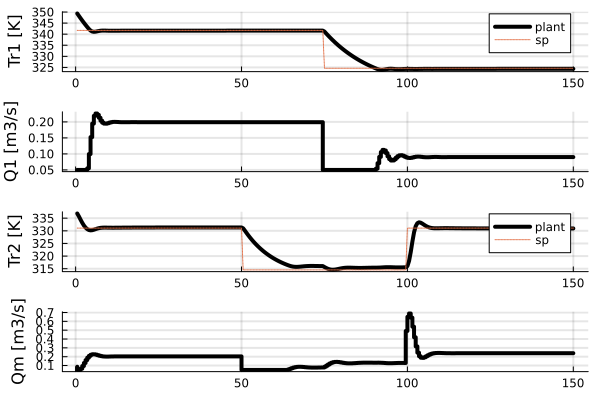

In [29]:
gr()

p14 = plot(t_mpc,Tr[1,:],linewidth=4,linecolor=:black,gridlinewidth=2,yaxis="Tr1 [K]")
p14 = plot!(t_mpc,T_sp[1,:],linestyle=:dot,)
p14.series_list[1][:label] = "plant"
p14.series_list[2][:label] = "sp"

p15 = plot(t_mpc,Qmpc[1,:],linetype=:steppre,linewidth=4,linecolor = :black,gridlinewidth=2,yaxis="Q1 [m3/s]",legend=false)

p16 = plot(t_mpc,Tr[2,:],linewidth=4,linecolor=:black,gridlinewidth=2,yaxis="Tr2 [K]")
p16 = plot!(t_mpc,T_sp[2,:],linestyle=:dot,)
p16.series_list[1][:label] = "plant"
p16.series_list[2][:label] = "sp"

p17 = plot(t_mpc,Qmpc[2,:],linetype=:steppre,linewidth=4,linecolor = :black,gridlinewidth=2,yaxis="Qm [m3/s]",legend=false)

g6 = plot(p14,p15,p16,p17,layout=(4,1))
display(g6)

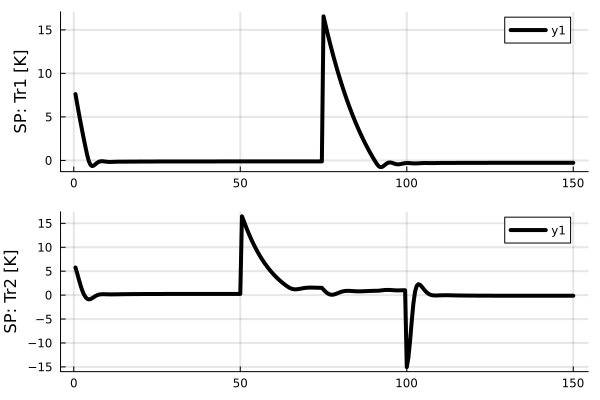

In [30]:
gr()

p18 = plot(t_mpc,Tr[1,:] - T_sp[1,:],linewidth=4,linecolor=:black,gridlinewidth=2,yaxis="SP: Tr1 [K]")
p19 = plot(t_mpc,Tr[2,:] - T_sp[2,:],linewidth=4,linecolor=:black,gridlinewidth=2,yaxis="SP: Tr2 [K]")

g7 = plot(p18,p19,layout=(2,1))
display(g7)

<a id="sec7"></a>

# Sensitivities of the model outputs w.r.t. uncertain parameters

- Data from the original paper of the uncertain parameters and the associated uncertainty

| $p$ | Nominal Value | $\sigma$ | 
| --- | --- | --- | 
| $T_1^{in}$ | 300K | 3 |
| $T_M$ | 300K | 3 |
| $Q_{c1}$ | 0.7 m3/s | 0.014 |
| $U_{a1}$ | 0.35 m3/s | 0.007 |
| $Q_{c2}$ | 0.7 m3/s | 0.014 |
| $U_{a2}$ | 0.35 m3/s | 0.007 |
| $k_{0II}$ | 160 1/s | 4 |

Rebuilding the model to include uncertain parameters as integrator parameters

In [31]:
function twoCSTRS_uncPar_dae!(dx, x, p, t)
    CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out,ofx = x
    Q1,Qm,T1_in,Tm_in,Ua1,Ua2,k0II = p
    
    # reactor 1
    dx[1] = (C1_in[1] - CA1)*Q1/V[1] - k0[1]*exp(-ER[1]/T1)*CA1 
    dx[2] = (C1_in[2] - CB1)*Q1/V[1] + k0[1]*exp(-ER[1]/T1)*CA1 - k0II*exp(-ER[2]/T1)*CB1
    dx[3] = (C1_in[3] - CC1)*Q1/V[1] + k0II*exp(-ER[2]/T1)*CB1
    dx[4] = (T1_in - T1)*Q1/V[1] - dH_pcp[1]*k0[1]*exp(-ER[1]/T1)*CA1 - dH_pcp[2]*k0II*exp(-ER[2]/T1)*CB1 - Ua1*(T1 - (0.5*(Tj1_out + Tj_in[1])))/V[1]
    dx[5] = Qj_in[1]*(Tj1_out - Tj_in[1]) - Ua1*(T1 - (0.5*(Tj1_out + Tj_in[1])))
    # reactor 2
    dx[6] = ((Q1*CA1 + Qm*Cm_in[1])/(Q1 + Qm) - CA2)*(Q1 + Qm)/V[2] - k0[1]*exp(-ER[1]/T2)*CA2 
    dx[7] = ((Q1*CB1 + Qm*Cm_in[2])/(Q1 + Qm) - CB2)*(Q1 + Qm)/V[2] + k0[1]*exp(-ER[1]/T2)*CA2 - k0II*exp(-ER[2]/T2)*CB2 
    dx[8] = ((Q1*CC1 + Qm*Cm_in[3])/(Q1 + Qm) - CC2)*(Q1 + Qm)/V[2] + k0II*exp(-ER[2]/T2)*CB2 
    dx[9] = ((Q1*T1 + Qm*Tm_in)/(Q1 + Qm) - T2)*(Q1 + Qm)/V[2] - dH_pcp[1]*k0[1]*exp(-ER[1]/T2)*CA2 - dH_pcp[2]*k0II*exp(-ER[2]/T2)*CB2 - Ua2*(T2 - (0.5*(Tj2_out + Tj_in[2])))/V[2]
    dx[10] = Qj_in[2]*(Tj2_out - Tj_in[2]) - Ua2*(T2 - (0.5*(Tj2_out + Tj_in[2])))
    # objective function
    dx[11] = 10*(Q1*C1_in[1] + Qm*Cm_in[1] - (Q1 + Qm)*(CA2 + CB2)) - 0.01*Ua1*(T1 - (0.5*(Tj1_out + Tj_in[1]))) - Ua2*(T2 - (0.5*(Tj2_out + Tj_in[2]))) - 0.1*Q1 - 0.1*Qm
    
    nothing
end

# mass matrix to determine algebraic equations
Mup = [1. 0 0 0 0 0 0 0 0 0 0;
       0 1. 0 0 0 0 0 0 0 0 0;
       0 0 1. 0 0 0 0 0 0 0 0;
       0 0 0 1. 0 0 0 0 0 0 0;
       0 0 0 0 0 0 0 0 0 0 0;
       0 0 0 0 0 1. 0 0 0 0 0;
       0 0 0 0 0 0 1. 0 0 0 0;
       0 0 0 0 0 0 0 1. 0 0 0;
       0 0 0 0 0 0 0 0 1. 0 0;
       0 0 0 0 0 0 0 0 0 0 0;
       0 0 0 0 0 0 0 0 0 0 1.]

# mass matrix to determine algebraic equations
ode_fun_ucp = ODEFunction(twoCSTRS_uncPar_dae!,mass_matrix=Mup);

Simulating system to compute sensitivities via finite differences

In [32]:
# simulation length = DRTO horizon
nspar = 20 

# parameters to be tested: T1_in, TM, Ua1, Ua2, k0II
nucp = 5
pNom = [300.0 300.0 0.35 0.35 160.0]
deltaPar = 0.01*[3.0 3.0 0.007 0.007 4.0]
deltaPsign = [-1.0 1.0]

# centered finite differences
nfd = 2 # + and - deltaP

# time series for plotting
# objective function
OF_s_data = Array{Float64}(undef,nfd,nucp,nspar)
# active contraints
Tr1_s_data = Array{Float64}(undef,nfd,nucp,nspar) 
Tc2_s_data = Array{Float64}(undef,nfd,nucp,nspar) 

for pp = 1:nucp
    for ff = 1:nfd
        
        # preparing simulation (starting from opt steady-state)
        xk = [x0_star;-o_star]
        uk = [Q0_star[1]; Qm0_star; pNom]
        
        # adding disturnance
        uk[2 + pp] =  uk[2 + pp] + deltaPsign[ff]*deltaPar[pp]

        for kk = 1:nspar
            display("Parameter $(pp), cfd evaluation $(ff): Iteration $(kk)")

            ode_prob_ucp = ODEProblem(ode_fun_ucp,xk,tspan,uk);
            sol =  solve(ode_prob_ucp, Rodas5(),reltol=1e-8,abstol=1e-8,save_everystep = false);

            # saving data
            Tr1_s_data[ff,pp,kk] = sol.u[end][4]
            Tc2_s_data[ff,pp,kk] = sol.u[end][10]
            OF_s_data[ff,pp,kk] = sol.u[end][11]

            # loop
            xk = sol.u[end]
        end 
    end
end;

"Parameter 1, cfd evaluation 1: Iteration 1"

"Parameter 1, cfd evaluation 1: Iteration 2"

"Parameter 1, cfd evaluation 1: Iteration 3"

"Parameter 1, cfd evaluation 1: Iteration 4"

"Parameter 1, cfd evaluation 1: Iteration 5"

"Parameter 1, cfd evaluation 1: Iteration 6"

"Parameter 1, cfd evaluation 1: Iteration 7"

"Parameter 1, cfd evaluation 1: Iteration 8"

"Parameter 1, cfd evaluation 1: Iteration 9"

"Parameter 1, cfd evaluation 1: Iteration 10"

"Parameter 1, cfd evaluation 1: Iteration 11"

"Parameter 1, cfd evaluation 1: Iteration 12"

"Parameter 1, cfd evaluation 1: Iteration 13"

"Parameter 1, cfd evaluation 1: Iteration 14"

"Parameter 1, cfd evaluation 1: Iteration 15"

"Parameter 1, cfd evaluation 1: Iteration 16"

"Parameter 1, cfd evaluation 1: Iteration 17"

"Parameter 1, cfd evaluation 1: Iteration 18"

"Parameter 1, cfd evaluation 1: Iteration 19"

"Parameter 1, cfd evaluation 1: Iteration 20"

"Parameter 1, cfd evaluation 2: Iteration 1"

"Parameter 1, cfd evaluation 2: Iteration 2"

"Parameter 1, cfd evaluation 2: Iteration 3"

"Parameter 1, cfd evaluation 2: Iteration 4"

"Parameter 1, cfd evaluation 2: Iteration 5"

"Parameter 1, cfd evaluation 2: Iteration 6"

"Parameter 1, cfd evaluation 2: Iteration 7"

"Parameter 1, cfd evaluation 2: Iteration 8"

"Parameter 1, cfd evaluation 2: Iteration 9"

"Parameter 1, cfd evaluation 2: Iteration 10"

"Parameter 1, cfd evaluation 2: Iteration 11"

"Parameter 1, cfd evaluation 2: Iteration 12"

"Parameter 1, cfd evaluation 2: Iteration 13"

"Parameter 1, cfd evaluation 2: Iteration 14"

"Parameter 1, cfd evaluation 2: Iteration 15"

"Parameter 1, cfd evaluation 2: Iteration 16"

"Parameter 1, cfd evaluation 2: Iteration 17"

"Parameter 1, cfd evaluation 2: Iteration 18"

"Parameter 1, cfd evaluation 2: Iteration 19"

"Parameter 1, cfd evaluation 2: Iteration 20"

"Parameter 2, cfd evaluation 1: Iteration 1"

"Parameter 2, cfd evaluation 1: Iteration 2"

"Parameter 2, cfd evaluation 1: Iteration 3"

"Parameter 2, cfd evaluation 1: Iteration 4"

"Parameter 2, cfd evaluation 1: Iteration 5"

"Parameter 2, cfd evaluation 1: Iteration 6"

"Parameter 2, cfd evaluation 1: Iteration 7"

"Parameter 2, cfd evaluation 1: Iteration 8"

"Parameter 2, cfd evaluation 1: Iteration 9"

"Parameter 2, cfd evaluation 1: Iteration 10"

"Parameter 2, cfd evaluation 1: Iteration 11"

"Parameter 2, cfd evaluation 1: Iteration 12"

"Parameter 2, cfd evaluation 1: Iteration 13"

"Parameter 2, cfd evaluation 1: Iteration 14"

"Parameter 2, cfd evaluation 1: Iteration 15"

"Parameter 2, cfd evaluation 1: Iteration 16"

"Parameter 2, cfd evaluation 1: Iteration 17"

"Parameter 2, cfd evaluation 1: Iteration 18"

"Parameter 2, cfd evaluation 1: Iteration 19"

"Parameter 2, cfd evaluation 1: Iteration 20"

"Parameter 2, cfd evaluation 2: Iteration 1"

"Parameter 2, cfd evaluation 2: Iteration 2"

"Parameter 2, cfd evaluation 2: Iteration 3"

"Parameter 2, cfd evaluation 2: Iteration 4"

"Parameter 2, cfd evaluation 2: Iteration 5"

"Parameter 2, cfd evaluation 2: Iteration 6"

"Parameter 2, cfd evaluation 2: Iteration 7"

"Parameter 2, cfd evaluation 2: Iteration 8"

"Parameter 2, cfd evaluation 2: Iteration 9"

"Parameter 2, cfd evaluation 2: Iteration 10"

"Parameter 2, cfd evaluation 2: Iteration 11"

"Parameter 2, cfd evaluation 2: Iteration 12"

"Parameter 2, cfd evaluation 2: Iteration 13"

"Parameter 2, cfd evaluation 2: Iteration 14"

"Parameter 2, cfd evaluation 2: Iteration 15"

"Parameter 2, cfd evaluation 2: Iteration 16"

"Parameter 2, cfd evaluation 2: Iteration 17"

"Parameter 2, cfd evaluation 2: Iteration 18"

"Parameter 2, cfd evaluation 2: Iteration 19"

"Parameter 2, cfd evaluation 2: Iteration 20"

"Parameter 3, cfd evaluation 1: Iteration 1"

"Parameter 3, cfd evaluation 1: Iteration 2"

"Parameter 3, cfd evaluation 1: Iteration 3"

"Parameter 3, cfd evaluation 1: Iteration 4"

"Parameter 3, cfd evaluation 1: Iteration 5"

"Parameter 3, cfd evaluation 1: Iteration 6"

"Parameter 3, cfd evaluation 1: Iteration 7"

"Parameter 3, cfd evaluation 1: Iteration 8"

"Parameter 3, cfd evaluation 1: Iteration 9"

"Parameter 3, cfd evaluation 1: Iteration 10"

"Parameter 3, cfd evaluation 1: Iteration 11"

"Parameter 3, cfd evaluation 1: Iteration 12"

"Parameter 3, cfd evaluation 1: Iteration 13"

"Parameter 3, cfd evaluation 1: Iteration 14"

"Parameter 3, cfd evaluation 1: Iteration 15"

"Parameter 3, cfd evaluation 1: Iteration 16"

"Parameter 3, cfd evaluation 1: Iteration 17"

"Parameter 3, cfd evaluation 1: Iteration 18"

"Parameter 3, cfd evaluation 1: Iteration 19"

"Parameter 3, cfd evaluation 1: Iteration 20"

"Parameter 3, cfd evaluation 2: Iteration 1"

"Parameter 3, cfd evaluation 2: Iteration 2"

"Parameter 3, cfd evaluation 2: Iteration 3"

"Parameter 3, cfd evaluation 2: Iteration 4"

"Parameter 3, cfd evaluation 2: Iteration 5"

"Parameter 3, cfd evaluation 2: Iteration 6"

"Parameter 3, cfd evaluation 2: Iteration 7"

"Parameter 3, cfd evaluation 2: Iteration 8"

"Parameter 3, cfd evaluation 2: Iteration 9"

"Parameter 3, cfd evaluation 2: Iteration 10"

"Parameter 3, cfd evaluation 2: Iteration 11"

"Parameter 3, cfd evaluation 2: Iteration 12"

"Parameter 3, cfd evaluation 2: Iteration 13"

"Parameter 3, cfd evaluation 2: Iteration 14"

"Parameter 3, cfd evaluation 2: Iteration 15"

"Parameter 3, cfd evaluation 2: Iteration 16"

"Parameter 3, cfd evaluation 2: Iteration 17"

"Parameter 3, cfd evaluation 2: Iteration 18"

"Parameter 3, cfd evaluation 2: Iteration 19"

"Parameter 3, cfd evaluation 2: Iteration 20"

"Parameter 4, cfd evaluation 1: Iteration 1"

"Parameter 4, cfd evaluation 1: Iteration 2"

"Parameter 4, cfd evaluation 1: Iteration 3"

"Parameter 4, cfd evaluation 1: Iteration 4"

"Parameter 4, cfd evaluation 1: Iteration 5"

"Parameter 4, cfd evaluation 1: Iteration 6"

"Parameter 4, cfd evaluation 1: Iteration 7"

"Parameter 4, cfd evaluation 1: Iteration 8"

"Parameter 4, cfd evaluation 1: Iteration 9"

"Parameter 4, cfd evaluation 1: Iteration 10"

"Parameter 4, cfd evaluation 1: Iteration 11"

"Parameter 4, cfd evaluation 1: Iteration 12"

"Parameter 4, cfd evaluation 1: Iteration 13"

"Parameter 4, cfd evaluation 1: Iteration 14"

"Parameter 4, cfd evaluation 1: Iteration 15"

"Parameter 4, cfd evaluation 1: Iteration 16"

"Parameter 4, cfd evaluation 1: Iteration 17"

"Parameter 4, cfd evaluation 1: Iteration 18"

"Parameter 4, cfd evaluation 1: Iteration 19"

"Parameter 4, cfd evaluation 1: Iteration 20"

"Parameter 4, cfd evaluation 2: Iteration 1"

"Parameter 4, cfd evaluation 2: Iteration 2"

"Parameter 4, cfd evaluation 2: Iteration 3"

"Parameter 4, cfd evaluation 2: Iteration 4"

"Parameter 4, cfd evaluation 2: Iteration 5"

"Parameter 4, cfd evaluation 2: Iteration 6"

"Parameter 4, cfd evaluation 2: Iteration 7"

"Parameter 4, cfd evaluation 2: Iteration 8"

"Parameter 4, cfd evaluation 2: Iteration 9"

"Parameter 4, cfd evaluation 2: Iteration 10"

"Parameter 4, cfd evaluation 2: Iteration 11"

"Parameter 4, cfd evaluation 2: Iteration 12"

"Parameter 4, cfd evaluation 2: Iteration 13"

"Parameter 4, cfd evaluation 2: Iteration 14"

"Parameter 4, cfd evaluation 2: Iteration 15"

"Parameter 4, cfd evaluation 2: Iteration 16"

"Parameter 4, cfd evaluation 2: Iteration 17"

"Parameter 4, cfd evaluation 2: Iteration 18"

"Parameter 4, cfd evaluation 2: Iteration 19"

"Parameter 4, cfd evaluation 2: Iteration 20"

"Parameter 5, cfd evaluation 1: Iteration 1"

"Parameter 5, cfd evaluation 1: Iteration 2"

"Parameter 5, cfd evaluation 1: Iteration 3"

"Parameter 5, cfd evaluation 1: Iteration 4"

"Parameter 5, cfd evaluation 1: Iteration 5"

"Parameter 5, cfd evaluation 1: Iteration 6"

"Parameter 5, cfd evaluation 1: Iteration 7"

"Parameter 5, cfd evaluation 1: Iteration 8"

"Parameter 5, cfd evaluation 1: Iteration 9"

"Parameter 5, cfd evaluation 1: Iteration 10"

"Parameter 5, cfd evaluation 1: Iteration 11"

"Parameter 5, cfd evaluation 1: Iteration 12"

"Parameter 5, cfd evaluation 1: Iteration 13"

"Parameter 5, cfd evaluation 1: Iteration 14"

"Parameter 5, cfd evaluation 1: Iteration 15"

"Parameter 5, cfd evaluation 1: Iteration 16"

"Parameter 5, cfd evaluation 1: Iteration 17"

"Parameter 5, cfd evaluation 1: Iteration 18"

"Parameter 5, cfd evaluation 1: Iteration 19"

"Parameter 5, cfd evaluation 1: Iteration 20"

"Parameter 5, cfd evaluation 2: Iteration 1"

"Parameter 5, cfd evaluation 2: Iteration 2"

"Parameter 5, cfd evaluation 2: Iteration 3"

"Parameter 5, cfd evaluation 2: Iteration 4"

"Parameter 5, cfd evaluation 2: Iteration 5"

"Parameter 5, cfd evaluation 2: Iteration 6"

"Parameter 5, cfd evaluation 2: Iteration 7"

"Parameter 5, cfd evaluation 2: Iteration 8"

"Parameter 5, cfd evaluation 2: Iteration 9"

"Parameter 5, cfd evaluation 2: Iteration 10"

"Parameter 5, cfd evaluation 2: Iteration 11"

"Parameter 5, cfd evaluation 2: Iteration 12"

"Parameter 5, cfd evaluation 2: Iteration 13"

"Parameter 5, cfd evaluation 2: Iteration 14"

"Parameter 5, cfd evaluation 2: Iteration 15"

"Parameter 5, cfd evaluation 2: Iteration 16"

"Parameter 5, cfd evaluation 2: Iteration 17"

"Parameter 5, cfd evaluation 2: Iteration 18"

"Parameter 5, cfd evaluation 2: Iteration 19"

"Parameter 5, cfd evaluation 2: Iteration 20"

Computing sensitivities using centered finite differences

In [33]:
# time series for plotting
t_sens = Vector{Float64}(undef,nspar) 
for kk in 1:nspar
    t_sens[kk] = dt*kk
end

# objective function
OF_sens = Array{Float64}(undef,nucp,nspar)
# active contraints
Tr1_sens = Array{Float64}(undef,nucp,nspar) 
Tc2_sens = Array{Float64}(undef,nucp,nspar) 

for pp = 1:nucp
    for kk = 1:nspar
        Tr1_sens[pp,kk] = (Tr1_s_data[2,pp,kk] - Tr1_s_data[1,pp,kk])/(2*deltaPar[pp])
        Tc2_sens[pp,kk] = (Tc2_s_data[2,pp,kk] - Tc2_s_data[1,pp,kk])/(2*deltaPar[pp])
        OF_sens[pp,kk] = (OF_s_data[2,pp,kk] - OF_s_data[1,pp,kk])/(2*deltaPar[pp])
    end 
end;

Plotting data

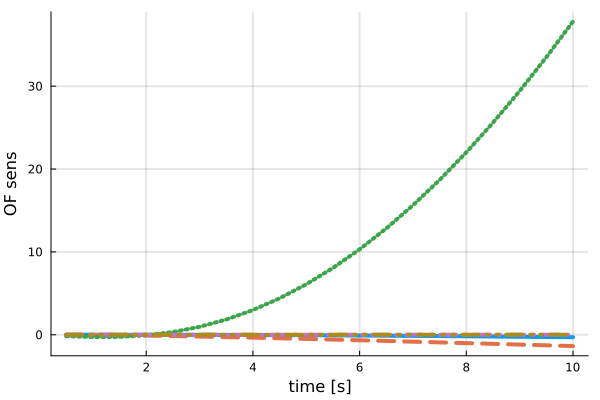

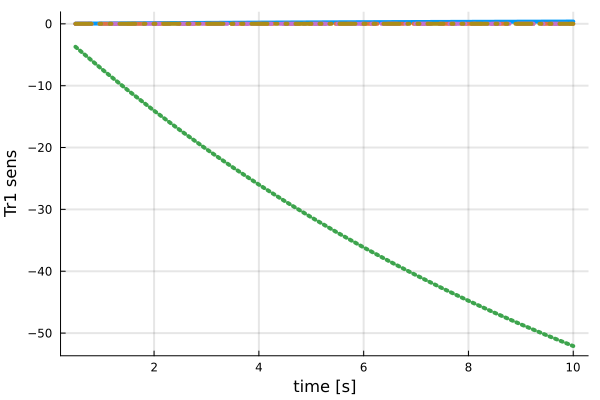

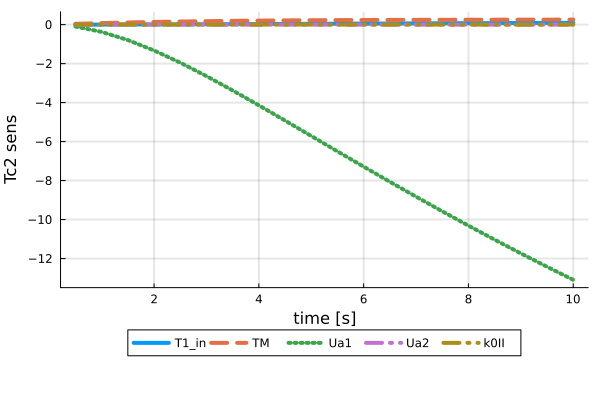

In [34]:
gr()

toflin = [:solid, :dash, :dot, :dashdot, :dashdotdot]

g8 = plot(t_sens,OF_sens[1,:],linewidth=4,linestyle=toflin[1],gridlinewidth=2,yaxis="OF sens",xaxis="time [s]", legend = false)
for pp = 2:nucp
    g8 = plot!(t_sens,OF_sens[pp,:],linewidth=4,linestyle=toflin[pp], legend = false)
end
display(g8)

g9 = plot(t_sens,Tr1_sens[1,:],linewidth=4,linestyle=toflin[1],gridlinewidth=2,yaxis="Tr1 sens",xaxis="time [s]", legend = false)
for pp = 2:nucp
    g9 = plot!(t_sens,Tr1_sens[pp,:],linewidth=4,linestyle=toflin[pp],legend = false)
end
display(g9)

g10 = plot(t_sens,Tc2_sens[1,:],linewidth=4,linestyle=toflin[1],gridlinewidth=2,yaxis="Tc2 sens",xaxis="time [s]", legend = :outerbottom, legendcolumns=5)
for pp = 2:nucp
    g10 = plot!(t_sens,Tc2_sens[pp,:],linewidth=4,linestyle=toflin[pp])
end
g10.series_list[1][:label] = "T1_in"
g10.series_list[2][:label] = "TM"
g10.series_list[3][:label] = "Ua1"
g10.series_list[4][:label] = "Ua2"
g10.series_list[5][:label] = "k0II"

display(g10)


<a id="sec8"></a>

# Testing deterministic CL-DRTO (one shot)

Tuning parameters from paper: *2018, Economic Coordination of Distributed Nonlinear MPC Systems using Closed-loop Prediction of a Nonlinear Dynamic Plant, H Li and C L E Swartz* 

In [35]:
# Optimization horizon 
ndrto = 20 # dt_DRTO

# time series for plotting
t_cldrto = Vector{Float64}(undef,ndrto) 
for kk in 1:ndrto
    t_cldrto[kk] = dt*kk
end

# Number of MPCs
numpc = 2 # reactor 1 (Q1 <-> T1), reactor 2 (Qm <-> T2)

# building MPC's
# reactor 1 MPC: T1 <-> Q1
mpc1 = MPC_matrices(a1_hat,b1_hat,1,p,m,q,r[1])
# reactor 2 MPC: T2 <-> Qm
mpc2 = MPC_matrices(a2_hat,b2_hat,1,p,m,q,r[2])

# Output bounds (T1, T2)
yMin = [100.0 100.0] #K
yMax = [350.0 350.0] #K

# Input bounds (Q1, Qm)
uMin = [0.050 0.050] #K
uMax = [0.805 0.800] #K

# Setpoint bounds (T1, T2)
yspMin = [100.0 100.0] #K
yspMax = [360.0 360.0] #K
    
yref = [T1_0_bar T2_0_bar]
uref = [Q1_0_bar Qm_0_bar]

# initial value of u
u0 = [Q0[1] Qm0];

# initial value of xMPC
xMPC0 = [T0[1] - T1_0_bar, T0[2] - T2_0_bar];

## Testing with unconstrained MPC

The FOC of the unconstrained MPC problem is:

$$ \dfrac{\partial J_k}{\partial u_k}\bigg|_{u_k^\star} = 2 \ u_k^{\star,T} \ H + 2c_f^T = 0 $$ 
 
Hence: 

$$ \ u_k^{\star,T} \ H + c_f^T = 0 $$ 
$$ \ u_k^{\star,T} \ H = - c_f^T $$ 

Transposing both sides ($H$ is symmetric, $H^T = H$):

$$ H \ u_k^{\star} = - c_f $$ 

In [36]:
# JuMP model
m_cldrto_uc = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_cldrto_uc, "warm_start_init_point", "yes")
set_optimizer_attribute(m_cldrto_uc, "print_level", 5)

####################
# Set up variables #
####################
# DRTO model variables
@variable(m_cldrto_uc, C[1:nc, 1:nrt, 1:ndrto, 1:ncp] ≥ 0)           # [kmol/m3] concentration (diff states)
@variable(m_cldrto_uc, T[rt=1:nrt, 1:ndrto, 1:ncp] ≥ Tj_in[rt])      # [K] reactor temperature (diff states)
@variable(m_cldrto_uc, Cdot[1:nc, 1:nrt, 1:ndrto, 1:ncp])            # [kmol/m3/s] concentration (time derivative)
@variable(m_cldrto_uc, Tdot[1:nrt, 1:ndrto, 1:ncp])                  # [K/s] reactor temperature (time derivative)
@variable(m_cldrto_uc, Tj_out[rt=1:nrt, 1:ndrto, 1:ncp] ≥ Tj_in[rt]) # [K] reactor temperature (diff states)
@variable(m_cldrto_uc, C_in[1:nc, 1:nrt, 1:ndrto, 1:ncp] ≥ 0)        # [kmol/m3] inlet concentration (alg. states)
@variable(m_cldrto_uc, T_in[rt=1:nrt, 1:ndrto, 1:ncp] ≥ Tj_in[rt])   # [K] inlet temperature (alg. states)
@variable(m_cldrto_uc, Q_min ≤ Q[1:nrt, 1:ndrto] ≤ Qf_max)           # [m3/s] flowrate to reactor
@variable(m_cldrto_uc, Qm_min ≤ Qm[1:ndrto] ≤ Qf_max)                # [m3/s] flowrate to mixer

# MPC model variables (SISO) -> deviation form
@variable(m_cldrto_uc, xMPC[1:numpc,1:ndrto])
@variable(m_cldrto_uc, yMPC[1:numpc,1:ndrto])
@variable(m_cldrto_uc, uMPC[1:numpc,1:ndrto,1:m]) #* unconstrained MPC is implemented first. MV's are clipped at DRTO level
    
# MPC <-> DRTO model deviation
@variable(m_cldrto_uc, de[1:numpc,1:ndrto])
    
# setpoints for the controllers sent to the plant (deviation variables, *CL-DRTO degrees of freedom)
@variable(m_cldrto_uc, yspMin[nct] ≤ ysp[nct = 1:numpc,1:ndrto] ≤ yspMax[nct])

# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for kk in 1:ndrto
    for jj in 1:ncp
        for rr in 1:nrt
            for cc in 1:nc
                # concentration related variables
                set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
                set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
            end # components loop
            
            # temperature related variables
            set_start_value(T[rr,kk,jj], T0_star[rr]) 
            set_start_value(T_in[rr,kk,jj], T_in0_star[rr])
            set_start_value(Tj_out[rr,kk,jj], Tj_out0_star[rr])
            
        end # reactors loop
    end # collocation points loop

    # MV's
    for rr in 1:nrt
        set_start_value(Q[rr,kk], Q0_star[rr])  
    end
    set_start_value(Qm[kk], Qm0_star) 
    
    for mm in 1:m
        set_start_value(uMPC[1,kk,mm], Q0_star[1] - uref[1])
        set_start_value(uMPC[2,kk,mm], Qm0_star - uref[2])
    end
end # finite elements loop

##############
# DRTO model #
##############
@NLexpressions(m_cldrto_uc, begin
        # [1/s] reaction rate
        k[rt = 1:nrt, rc = 1:nrc, kk = 1:ndrto, jj = 1:ncp], k0[rc]*exp(-ER[rc]/T[rt,kk,jj])
        #[m3 K/s] cooling rate
        # approximate model *approximating logarithm temperature
        qcool[rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp], Ua[rt]*(T[rt,kk,jj] - (0.5*(Tj_out[rt,kk,jj] + Tj_in[rt])))
end)

@NLconstraints(m_cldrto_uc, begin
        #########
        # MODEL #
        #########    
        # reactor
        r_cmb[co = 1:nc, rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp], Cdot[co,rt,kk,jj] == (C_in[co,rt,kk,jj] - C[co,rt,kk,jj])*Q[rt,kk]/V[rt] + sum(Ms[co,rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) 
        r_eb[rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp], Tdot[rt,kk,jj] == (T_in[rt,kk,jj] - T[rt,kk,jj])*Q[rt,kk]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) - qcool[rt,kk,jj]/V[rt]
        # mixer
        m_mb[kk = 1:ndrto], 0 == Q[1,kk] + Qm[kk] - Q[2,kk]
        m_cmb[co = 1:nc,kk = 1:ndrto,jj = 1:ncp], 0 == Q[1,kk]*C[co,1,kk,jj] + Qm[kk]*Cm_in[co] - Q[2,kk]*C_in[co,2,kk,jj]
        m_eb[kk = 1:ndrto,jj = 1:ncp], 0 == Q[1,kk]*T[1,kk,jj] + Qm[kk]*Tm_in - Q[2,kk]*T_in[2,kk,jj]
        # jacket
        j_eb[rt = 1:nrt,kk = 1:ndrto,jj = 1:ncp], 0 == Qj_in[rt]*(Tj_out[rt,kk,jj] - Tj_in[rt]) - qcool[rt,kk,jj]

        #########################    
        # Collocation Equations #    
        #########################
        # set up collocation equations - 2nd-to-nth point
        coll_C_n[co = 1:nc, rt = 1:nrt, kk = 2:ndrto, jj = 1:ncp], C[co,rt,kk,jj] == C[co,rt,kk-1,ncp] + h*sum(colmat[jj,ii]*Cdot[co,rt,kk,ii] for ii in 1:ncp)    
        coll_T_n[rt = 1:nrt, kk = 2:ndrto, jj = 1:ncp], T[rt,kk,jj] == T[rt,kk-1,ncp] + h*sum(colmat[jj,ii]*Tdot[rt,kk,ii] for ii in 1:ncp)

        # set up collocation equations - 1st point
        coll_C_0[co=1:nc, rt = 1:nrt, kk = [1], jj = 1:ncp], C[co,rt,kk,jj] == C0[co,rt] + h*sum(colmat[jj,ii]*Cdot[co,rt,kk,ii] for ii in 1:ncp)
        coll_T_0[rt = 1:nrt, kk = [1], jj = 1:ncp], T[rt,kk,jj] == T0[rt] + h*sum(colmat[jj,ii]*Tdot[rt,kk,ii] for ii in 1:ncp)
end)

##########################
# MPC model and solution #
##########################
# N.B. inside MPC everything is in deviation variables
@expressions(m_cldrto_uc, begin
        # MPC1
        cfT_c1_1, (mpc1['Ψ']*[xMPC[1,1];de[1,1]] .- (ysp[1,1] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - (u0[1] - uref[1])*mpc1['I']'*mpc1['R']*mpc1['M']
        cfT_c1[kk=2:ndrto], (mpc1['Ψ']*[xMPC[1,kk];de[1,kk]] .- (ysp[1,kk] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - uMPC[1,kk - 1,1]*mpc1['I']'*mpc1['R']*mpc1['M']
        # MPC2
        cfT_c2_1, (mpc2['Ψ']*[xMPC[2,1];de[2,1]] .- (ysp[2,1] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - (u0[2] - uref[2])*mpc2['I']'*mpc2['R']*mpc2['M']
        cfT_c2[kk=2:ndrto], (mpc2['Ψ']*[xMPC[2,kk];de[2,kk]] .- (ysp[2,kk] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - uMPC[2,kk - 1,1]*mpc2['I']'*mpc2['R']*mpc2['M']
end)

@constraints(m_cldrto_uc, begin
        #############
        # MPC model #
        #############
        # MPC1
        MPC1_dyn_model_1, xMPC[1,1] == mpc1['A']*xMPC0[1] + mpc1['B']*(u0[1] - uref[1])
        MPC1_dyn_model[kk = 1:(ndrto - 1)], xMPC[1,kk + 1] == mpc1['A']*xMPC[1,kk] + mpc1['B']*uMPC[1,kk,1]
        MPC1_model_out[kk=1:ndrto], yMPC[1,kk] == xMPC[1,kk] # C = 1
        MPC1_model_dev[kk=1:ndrto], de[1,kk] == (T[1,kk,ncp] - yref[1]) - yMPC[1,kk]
        # MPC12
        MPC2_dyn_model_1, xMPC[2,1] == mpc2['A']*xMPC0[2] + mpc2['B']*(u0[2] - uref[2])
        MPC2_dyn_model[kk = 1:(ndrto - 1)], xMPC[2,kk + 1] == mpc2['A']*xMPC[2,kk] + mpc2['B']*uMPC[2,kk,1]
        MPC2_model_out[kk=1:ndrto], yMPC[2,kk] == xMPC[2,kk] 
        MPC2_model_dev[kk=1:ndrto], de[2,kk] == (T[2,kk,ncp] - yref[2]) - yMPC[2,kk]
        ################
        # MPC solution #
        ################
        # MPC1
        MPC1_sol_1, mpc1['H']*uMPC[1,1,:] + cfT_c1_1' .== 0
        MPC1_sol[kk=2:ndrto], mpc1['H']*uMPC[1,kk,:] + cfT_c1[kk]' .== 0
        # MPC2
        MPC2_sol_1, mpc2['H']*uMPC[2,1,:] + cfT_c2_1' .== 0
        MPC2_sol[kk=2:ndrto], mpc2['H']*uMPC[2,kk,:] + cfT_c2[kk]' .== 0        
end)

@constraints(m_cldrto_uc, begin   
        #######################
        # PROCESS CONSTRAINTS #
        #######################
        # ! Enforcing only at the end of the finite element
        # safety restrictions
        g1[rt = 1:nrt, kk = 1:ndrto], T[rt,kk,ncp] - Tr_max ≤ 0
        # product specifications (Concentration of A in reactor 2)
        g2[kk = 1:ndrto], C[1,2,kk,ncp] - cA2_max ≤ 0
        # feed supply limitations
        g3[kk = 1:ndrto], Q[1,kk] + Qm[kk] - Qf_max ≤ 0
        # process limitations (others have been included when declaring variables): max cooling water outlet temperature
        g4[rt = 1:nrt, kk = 1:ndrto], Tj_out[rt,kk,ncp] - Tj_max[rt] ≤ 0    
        ############################
        # OPTIMIZATION CONSTRAINTS #
        ############################
        # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
        h1[kk = 1:ndrto], (uMPC[1,kk,1] + uref[1]) - Q[1,kk] == 0
        h2[kk = 1:ndrto], (uMPC[2,kk,1] + uref[2]) - Qm[kk] == 0
        ##############    
        # PARAMETERS #
        ##############
        p1[co = 1:nc,kk = 1:ndrto,jj = 1:ncp], C_in[co,1,kk,jj] - C1_in[co] == 0
        p2[kk = 1:ndrto,jj = 1:ncp], T_in[1,kk,jj] - T1_in == 0
    end)

# Set up objective function  
@NLobjective(m_cldrto_uc, Min, -sum(h*(sum(
                                (
                                (10*(Q[1,kk]*C_in[1,1,kk,jj] + Qm[kk]*Cm_in[1] - Q[2,kk]*(C[1,2,kk,jj] + C[3,2,kk,jj])) - 0.01*qcool[1,kk,jj] - qcool[2,kk,jj] - 0.1*Q[1,kk] - 0.1*Qm[kk])
                                )*colmat[ncp,jj]
                                for jj in 1:ncp
                               )
                           ) for kk in 1:nfe
                        )
            )

# @show model_ms
optimize!(m_cldrto_uc)
flag = termination_status(m_cldrto_uc)
# primal_status(m_cldrto_uc)
    
#calling values of the solved problem
o = objective_value(m_cldrto_uc)
yspArray_uc = value.(ysp)

# time series for plotting
Q_cldro_uc = value.(Q[1,:])
Qm_cldrto_uc = value.(Qm)

Tr_cldrto_uc = Matrix{Float64}(undef,nrt,ndrto)
Tj_cldrto_uc = Matrix{Float64}(undef,nrt,ndrto)

for rt in 1:nrt
    Tr_cldrto_uc[rt,:] = value.(T[rt,:,3])
    Tj_cldrto_uc[rt,:] = value.(Tj_out[rt,:,3])
end


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     8390
Number of nonzeros in inequality constraint Jacobian.:      140
Number of nonzeros in Lagrangian Hessian.............:     6820

Total number of variables............................:     1900
                     variables with only lower bounds:     1080
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1860
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.6116528e+02 7.70e+03 9.99e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

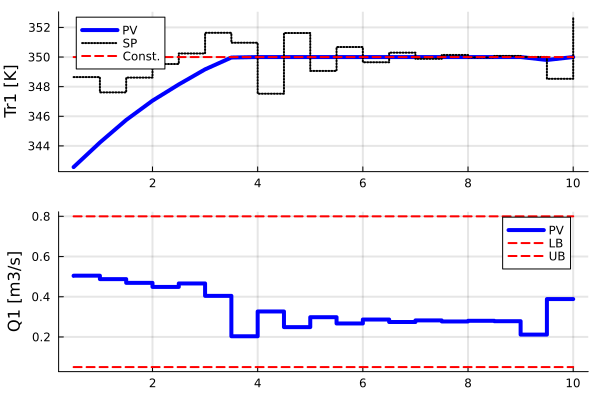

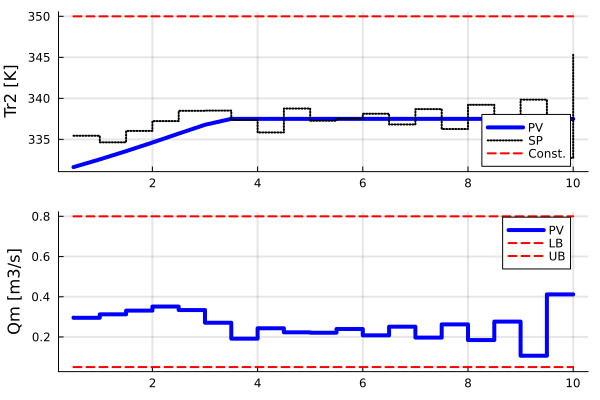

In [37]:
gr() #g11 p20

p20 = plot(t_cldrto,Tr_cldrto_uc[1,:],linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Tr1 [K]")
p20 = plot!(t_cldrto,yspArray_uc[1,:],linewidth=2,linetype=:steppost,linestyle = :dot, linecolor = :black)
p20 = plot!(t_cldrto,Tr_max*ones(length(t_cldrto)),linewidth=2,linestyle = :dash, linecolor = :red)
p20.series_list[1][:label] = "PV"
p20.series_list[2][:label] = "SP"
p20.series_list[3][:label] = "Const."

p21 = plot(t_cldrto,Q_cldro_uc,linetype=:steppre,linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Q1 [m3/s]")
p21 = plot!(t_cldrto,Q_min*ones(length(t_cldrto)),linewidth=2,linestyle = :dash, linecolor = :red)
p21 = plot!(t_cldrto,Qf_max*ones(length(t_cldrto)),linewidth=2,linestyle = :dash, linecolor = :red)
p21.series_list[1][:label] = "PV"
p21.series_list[2][:label] = "LB"
p21.series_list[3][:label] = "UB"

g11 = plot(p20,p21,layout=(2,1))
display(g11)

p22 = plot(t_cldrto,Tr_cldrto_uc[2,:],linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Tr2 [K]")
p22 = plot!(t_cldrto,yspArray_uc[2,:],linewidth=2,linetype=:steppost,linestyle = :dot, linecolor = :black)
p22 = plot!(t_cldrto,Tr_max*ones(length(t_cldrto)),linewidth=2,linestyle = :dash, linecolor = :red)
p22.series_list[1][:label] = "PV"
p22.series_list[2][:label] = "SP"
p22.series_list[3][:label] = "Const."

p23 = plot(t_cldrto,Qm_cldrto_uc,linetype=:steppre,linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Qm [m3/s]")
p23 = plot!(t_cldrto,Q_min*ones(length(t_cldrto)),linewidth=2,linestyle = :dash, linecolor = :red)
p23 = plot!(t_cldrto,Qf_max*ones(length(t_cldrto)),linewidth=2,linestyle = :dash, linecolor = :red)
p23.series_list[1][:label] = "PV"
p23.series_list[2][:label] = "LB"
p23.series_list[3][:label] = "UB"
g12 = plot(p22,p23,layout=(2,1))
display(g12)


## Testing with constrained MPC

Since we are considering constraints, the optimization problem reads as:

$$ min_{u_k} J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

$$ s.t.: u_{min} \leq u_k \leq u_{max}  \quad k = 1,\ldots,m $$ 
 
considering m = 3, we can rewrite the constraints as:

$ u_k - u_{max} \leq 0 \quad k = 1,2,3  $ <br>
$ u_{min} - u_k \leq 0 \quad k = 1,2,3  $ <br>

**Solving the problem via KKT**

The Lagrangian of the problem above is: 
$$ L = u_k^T \ H \ u_k + 2c_f^T \ u_k + c + 
\begin{vmatrix}
\mu_{UB,1} \ \mu_{UB,2} \ \mu_{UB,3} \ \mu_{LB,1} \ \mu_{LB,2} \ \mu_{LB,3}
\end{vmatrix} 
\begin{vmatrix}
u_{max} - u_1\\ u_{max} - u_2 \\ u_{max} - u_3 \\ u_1 - u_{min} \\ u_2 - u_{min}\\ u_3 - u_{min}
\end{vmatrix}
$$

The KKT conditions can be written as

- Stationarity of the Lagrangian <br>
$ \nabla_u L = 
\begin{vmatrix}
u_{1} & u_{2} & u_{3}
\end{vmatrix} 
\ H + c_f^T +  
\begin{vmatrix}
\mu_{UB,1} & \mu_{UB,2} & \mu_{UB,3} & \mu_{LB,1} & \mu_{LB,2} & \mu_{LB,3}
\end{vmatrix} 
\begin{vmatrix}
-1 & 0 & 0 \\ 0 & -1 & 0 \\ 0 & 0 & -1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1
\end{vmatrix}
$ <br>

- Primal Feasibility <br>
$
\begin{vmatrix}
u_{max} - u_1\\ u_{max} - u_2 \\ u_{max} - u_3 \\ u_1 - u_{min} \\ u_2 - u_{min}\\ u_3 - u_{min}
\end{vmatrix}
\geq 0
$ <br>

- Dual Feasibility <br>
$
\begin{vmatrix}
\mu_{UB,1} \\ \mu_{UB,2} \\ \mu_{UB,3} \\ \mu_{LB,1} \\ \mu_{LB,2} \\ \mu_{LB,3}
\end{vmatrix}
\geq 0
$ <br>

- Complementarity Slackness <br>
$
\begin{vmatrix}
\mu_{UB,1} & \mu_{UB,2} & \mu_{UB,3} & \mu_{LB,1} & \mu_{LB,2} & \mu_{LB,3}
\end{vmatrix}
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
= 0
$ <br>

**Using Regularized Fischer-burmeister function $\psi$ to represent complementarity slackness**

Using the first complementarity constraint as an example, and representing $\mu_{UB,1}$ and $u_{max} - u_1$ as $a$ and $b$, respectively. 

We have:

$$ \Psi = a + b - \sqrt{a^2 + b^2 + \epsilon} = 0$$

for some small $\epsilon > 0$

We can repeat the same procedure for all complementarity constraints

In [38]:
# Parameters
# matrix to compute the gradients of the input bound constraints
conMatrix = [-I(m); I(m)]

# Regularized FB function 
epsFB = [1e-6 1e-6 1e-6 1e-6 1e-6 1e-6];

In [44]:
# JuMP model
m_cldrto_c = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_cldrto_c, "warm_start_init_point", "yes")
set_optimizer_attribute(m_cldrto_c, "print_level", 5)

####################
# Set up variables #
####################
# DRTO model variables
@variable(m_cldrto_c, C[1:nc, 1:nrt, 1:ndrto, 1:ncp] ≥ 0)           # [kmol/m3] concentration (diff states)
@variable(m_cldrto_c, T[rt=1:nrt, 1:ndrto, 1:ncp] ≥ Tj_in[rt])      # [K] reactor temperature (diff states)
@variable(m_cldrto_c, Cdot[1:nc, 1:nrt, 1:ndrto, 1:ncp])            # [kmol/m3/s] concentration (time derivative)
@variable(m_cldrto_c, Tdot[1:nrt, 1:ndrto, 1:ncp])                  # [K/s] reactor temperature (time derivative)
@variable(m_cldrto_c, Tj_out[rt=1:nrt, 1:ndrto, 1:ncp] ≥ Tj_in[rt]) # [K] reactor temperature (diff states)
@variable(m_cldrto_c, C_in[1:nc, 1:nrt, 1:ndrto, 1:ncp] ≥ 0)        # [kmol/m3] inlet concentration (alg. states)
@variable(m_cldrto_c, T_in[rt=1:nrt, 1:ndrto, 1:ncp] ≥ Tj_in[rt])   # [K] inlet temperature (alg. states)
@variable(m_cldrto_c, Q_min ≤ Q[1:nrt, 1:ndrto] ≤ Qf_max)           # [m3/s] flowrate to reactor
@variable(m_cldrto_c, Qm_min ≤ Qm[1:ndrto] ≤ Qf_max)                # [m3/s] flowrate to mixer

# MPC model variables (SISO) -> deviation form
@variable(m_cldrto_c, xMPC[1:numpc,1:ndrto])
@variable(m_cldrto_c, yMPC[1:numpc,1:ndrto])
@variable(m_cldrto_c, uMPC[1:numpc,1:ndrto,1:m]) #* unconstrained MPC is implemented first. MV's are clipped at DRTO level
    
# MPC <-> DRTO model deviation
@variable(m_cldrto_c, de[1:numpc,1:ndrto])

# Constrained MPC KKT conditions (upper and lower bounds for each input)
@variable(m_cldrto_c, mu_g[1:numpc,1:ndrto,1:(2*m)] ≥ 0, start = 0) 

# setpoints for the controllers sent to the plant (deviation variables, *CL-DRTO degrees of freedom)
@variable(m_cldrto_c, yspMin[nct] ≤ ysp[nct = 1:numpc,1:ndrto] ≤ yspMax[nct])

# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for kk in 1:ndrto
    for jj in 1:ncp
        for rr in 1:nrt
            for cc in 1:nc
                # concentration related variables
                set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
                set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
            end # components loop
            
            # temperature related variables
            set_start_value(T[rr,kk,jj], T0_star[rr]) 
            set_start_value(T_in[rr,kk,jj], T_in0_star[rr])
            set_start_value(Tj_out[rr,kk,jj], Tj_out0_star[rr])
            
        end # reactors loop
    end # collocation points loop

    # MV's
    for rr in 1:nrt
        set_start_value(Q[rr,kk], Q0_star[rr])  
    end
    set_start_value(Qm[kk], Qm0_star) 
    
    for mm in 1:m
        set_start_value(uMPC[1,kk,mm], Q0_star[1] - uref[1])
        set_start_value(uMPC[2,kk,mm], Qm0_star - uref[2])
    end
end # finite elements loop

##############
# DRTO model #
##############
@NLexpressions(m_cldrto_c, begin
        # [1/s] reaction rate
        k[rt = 1:nrt, rc = 1:nrc, kk = 1:ndrto, jj = 1:ncp], k0[rc]*exp(-ER[rc]/T[rt,kk,jj])
        #[m3 K/s] cooling rate
        # approximate model *approximating logarithm temperature
        qcool[rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp], Ua[rt]*(T[rt,kk,jj] - (0.5*(Tj_out[rt,kk,jj] + Tj_in[rt])))
end)

@NLconstraints(m_cldrto_c, begin
        #########
        # MODEL #
        #########    
        # reactor
        r_cmb[co = 1:nc, rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp], Cdot[co,rt,kk,jj] == (C_in[co,rt,kk,jj] - C[co,rt,kk,jj])*Q[rt,kk]/V[rt] + sum(Ms[co,rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) 
        r_eb[rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp], Tdot[rt,kk,jj] == (T_in[rt,kk,jj] - T[rt,kk,jj])*Q[rt,kk]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) - qcool[rt,kk,jj]/V[rt]
        # mixer
        m_mb[kk = 1:ndrto], 0 == Q[1,kk] + Qm[kk] - Q[2,kk]
        m_cmb[co = 1:nc,kk = 1:ndrto,jj = 1:ncp], 0 == Q[1,kk]*C[co,1,kk,jj] + Qm[kk]*Cm_in[co] - Q[2,kk]*C_in[co,2,kk,jj]
        m_eb[kk = 1:ndrto,jj = 1:ncp], 0 == Q[1,kk]*T[1,kk,jj] + Qm[kk]*Tm_in - Q[2,kk]*T_in[2,kk,jj]
        # jacket
        j_eb[rt = 1:nrt,kk = 1:ndrto,jj = 1:ncp], 0 == Qj_in[rt]*(Tj_out[rt,kk,jj] - Tj_in[rt]) - qcool[rt,kk,jj]

        #########################    
        # Collocation Equations #    
        #########################
        # set up collocation equations - 2nd-to-nth point
        coll_C_n[co = 1:nc, rt = 1:nrt, kk = 2:ndrto, jj = 1:ncp], C[co,rt,kk,jj] == C[co,rt,kk-1,ncp] + h*sum(colmat[jj,ii]*Cdot[co,rt,kk,ii] for ii in 1:ncp)    
        coll_T_n[rt = 1:nrt, kk = 2:ndrto, jj = 1:ncp], T[rt,kk,jj] == T[rt,kk-1,ncp] + h*sum(colmat[jj,ii]*Tdot[rt,kk,ii] for ii in 1:ncp)

        # set up collocation equations - 1st point
        coll_C_0[co=1:nc, rt = 1:nrt, kk = [1], jj = 1:ncp], C[co,rt,kk,jj] == C0[co,rt] + h*sum(colmat[jj,ii]*Cdot[co,rt,kk,ii] for ii in 1:ncp)
        coll_T_0[rt = 1:nrt, kk = [1], jj = 1:ncp], T[rt,kk,jj] == T0[rt] + h*sum(colmat[jj,ii]*Tdot[rt,kk,ii] for ii in 1:ncp)
end)

##########################
# MPC model and solution #
##########################
# N.B. inside MPC everything is in deviation variables
@expressions(m_cldrto_c, begin
        # MPC1
        # Objective function term
        cfT_c1_1, (mpc1['Ψ']*[xMPC[1,1];de[1,1]] .- (ysp[1,1] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - (u0[1] - uref[1])*mpc1['I']'*mpc1['R']*mpc1['M']
        cfT_c1[kk=2:ndrto], (mpc1['Ψ']*[xMPC[1,kk];de[1,kk]] .- (ysp[1,kk] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - uMPC[1,kk - 1,1]*mpc1['I']'*mpc1['R']*mpc1['M']
        # Input bounds
        MPC1_u_upper[kk = 1:ndrto,uu = 1:m], (uMax[1] - uref[1]) - uMPC[1,kk,uu]
        MPC1_u_lower[kk = 1:ndrto,uu = 1:m], uMPC[1,kk,uu] - (uMin[1] - uref[1])
        # MPC2
        # Objective function term
        cfT_c2_1, (mpc2['Ψ']*[xMPC[2,1];de[2,1]] .- (ysp[2,1] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - (u0[2] - uref[2])*mpc2['I']'*mpc2['R']*mpc2['M']
        cfT_c2[kk=2:ndrto], (mpc2['Ψ']*[xMPC[2,kk];de[2,kk]] .- (ysp[2,kk] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - uMPC[2,kk - 1,1]*mpc2['I']'*mpc2['R']*mpc2['M']
        # Input bounds
        MPC2_u_upper[kk = 1:ndrto,uu = 1:m], (uMax[2] - uref[2]) - uMPC[2,kk,uu]
        MPC2_u_lower[kk = 1:ndrto,uu = 1:m], uMPC[2,kk,uu] - (uMin[2] - uref[2])
end)

@constraints(m_cldrto_c, begin
        #############
        # MPC model #
        #############
        # MPC1
        MPC1_dyn_model_1, xMPC[1,1] == mpc1['A']*xMPC0[1] + mpc1['B']*(u0[1] - uref[1])
        MPC1_dyn_model[kk = 1:(ndrto - 1)], xMPC[1,kk + 1] == mpc1['A']*xMPC[1,kk] + mpc1['B']*uMPC[1,kk,1]
        MPC1_model_out[kk=1:ndrto], yMPC[1,kk] == xMPC[1,kk] # C = 1
        MPC1_model_dev[kk=1:ndrto], de[1,kk] == (T[1,kk,ncp] - yref[1]) - yMPC[1,kk]
        # MPC12
        MPC2_dyn_model_1, xMPC[2,1] == mpc2['A']*xMPC0[2] + mpc2['B']*(u0[2] - uref[2])
        MPC2_dyn_model[kk = 1:(ndrto - 1)], xMPC[2,kk + 1] == mpc2['A']*xMPC[2,kk] + mpc2['B']*uMPC[2,kk,1]
        MPC2_model_out[kk=1:ndrto], yMPC[2,kk] == xMPC[2,kk] 
        MPC2_model_dev[kk=1:ndrto], de[2,kk] == (T[2,kk,ncp] - yref[2]) - yMPC[2,kk]
        ################
        # MPC solution #
        ################
        # MPC 1
        # stationarity
        MPC1_sol_sta_1, uMPC[1,1,:]'*mpc1['H'] + cfT_c1_1 +  mu_g[1,1,:]'*conMatrix .== 0
        MPC1_sol_sta[kk=2:ndrto], uMPC[1,kk,:]'*mpc1['H'] + cfT_c1[kk] +  mu_g[1,kk,:]'*conMatrix .== 0
        # primal feasibility
        MPC1_sol_feas_ub[kk = 1:ndrto,uu = 1:m], MPC1_u_upper[kk,uu] ≥ 0
        MPC1_sol_feas_lb[kk = 1:ndrto,uu = 1:m], MPC1_u_lower[kk,uu] ≥ 0
        # dual feasibility (already defined above)
        # complementarity constraint (defined below since it is nonlinear)
        # MPC 2
        # stationarity
        MPC2_sol_sta_1, uMPC[2,1,:]'*mpc2['H'] + cfT_c2_1 +  mu_g[2,1,:]'*conMatrix .== 0
        MPC2_sol_sta[kk=2:ndrto], uMPC[2,kk,:]'*mpc2['H'] + cfT_c2[kk] +  mu_g[2,kk,:]'*conMatrix .== 0
        # primal feasibility
        MPC2_sol_feas_ub[kk = 1:ndrto,uu = 1:m], MPC2_u_upper[kk,uu] ≥ 0
        MPC2_sol_feas_lb[kk = 1:ndrto,uu = 1:m], MPC2_u_lower[kk,uu] ≥ 0
        # dual feasibility (already defined above)
        # complementarity constraint (defined below since it is nonlinear)
end)

@NLconstraints(m_cldrto_c, begin
        # MPC 1 
        # complementarity constraint
        MPC1_sol_cc_ub[kk = 1:ndrto,uu = 1:m], mu_g[1,kk,uu] + MPC1_u_upper[kk,uu] - sqrt(mu_g[1,kk,uu]^2 + MPC1_u_upper[kk,uu]^2 + epsFB[uu]) == 0
        MPC1_sol_cc_lb[kk = 1:ndrto,uu = 1:m], mu_g[1,kk,m + uu] + MPC1_u_lower[kk,uu] - sqrt(mu_g[1,kk,m + uu]^2 + MPC1_u_lower[kk,uu]^2 + epsFB[m + uu]) == 0    
        # MPC 2
        # complementarity constraint
        MPC2_sol_cc_ub[kk = 1:ndrto,uu = 1:m], mu_g[2,kk,uu] + MPC2_u_upper[kk,uu] - sqrt(mu_g[2,kk,uu]^2 + MPC2_u_upper[kk,uu]^2 + epsFB[uu]) == 0 
        MPC2_sol_cc_lb[kk = 1:ndrto,uu = 1:m], mu_g[2,kk,m + uu] + MPC2_u_lower[kk,uu] - sqrt(mu_g[2,kk,m + uu]^2 + MPC2_u_lower[kk,uu]^2 + epsFB[m + uu]) == 0 
end)

@constraints(m_cldrto_c, begin   
        #######################
        # PROCESS CONSTRAINTS #
        #######################
        # ! Enforcing only at the end of the finite element
        # safety restrictions
        g1[rt = 1:nrt, kk = 1:ndrto], T[rt,kk,ncp] - Tr_max ≤ 0
        # product specifications (Concentration of A in reactor 2)
        g2[kk = 1:ndrto], C[1,2,kk,ncp] - cA2_max ≤ 0
        # feed supply limitations
        g3[kk = 1:ndrto], Q[1,kk] + Qm[kk] - Qf_max ≤ 0
        # process limitations (others have been included when declaring variables): max cooling water outlet temperature
        g4[rt = 1:nrt, kk = 1:ndrto], Tj_out[rt,kk,ncp] - Tj_max[rt] ≤ 0    
        ############################
        # OPTIMIZATION CONSTRAINTS #
        ############################
        # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
        h1[kk = 1:ndrto], (uMPC[1,kk,1] + uref[1]) - Q[1,kk] == 0
        h2[kk = 1:ndrto], (uMPC[2,kk,1] + uref[2]) - Qm[kk] == 0
        ##############    
        # PARAMETERS #
        ##############
        p1[co = 1:nc,kk = 1:ndrto,jj = 1:ncp], C_in[co,1,kk,jj] - C1_in[co] == 0
        p2[kk = 1:ndrto,jj = 1:ncp], T_in[1,kk,jj] - T1_in == 0
    end)

# Set up objective function  
@NLobjective(m_cldrto_c, Min, -sum(h*(sum(
                                (
                                (10*(Q[1,kk]*C_in[1,1,kk,jj] + Qm[kk]*Cm_in[1] - Q[2,kk]*(C[1,2,kk,jj] + C[3,2,kk,jj])) - 0.01*qcool[1,kk,jj] - qcool[2,kk,jj] - 0.1*Q[1,kk] - 0.1*Qm[kk])
                                )*colmat[ncp,jj]
                                for jj in 1:ncp
                               )
                           ) for kk in 1:nfe
                        )
            )

# @show model_ms
optimize!(m_cldrto_c)
flag = termination_status(m_cldrto_c)
# primal_status(m_cldrto_uc)
    
#calling values of the solved problem
o = objective_value(m_cldrto_c)
yspArray_c = value.(ysp)

# time series for plotting
Q_cldro_c = value.(Q[1,:])
Qm_cldrto_c = value.(Qm)

Tr_cldrto_c = Matrix{Float64}(undef,nrt,ndrto)
Tj_cldrto_c = Matrix{Float64}(undef,nrt,ndrto)

for rt in 1:nrt
    Tr_cldrto_c[rt,:] = value.(T[rt,:,3])
    Tj_cldrto_c[rt,:] = value.(Tj_out[rt,:,3])
end


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9110
Number of nonzeros in inequality constraint Jacobian.:      380
Number of nonzeros in Lagrangian Hessian.............:     7540

Total number of variables............................:     2140
                     variables with only lower bounds:     1320
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2100
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.6116528e+02 7.70e+03 9.99e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

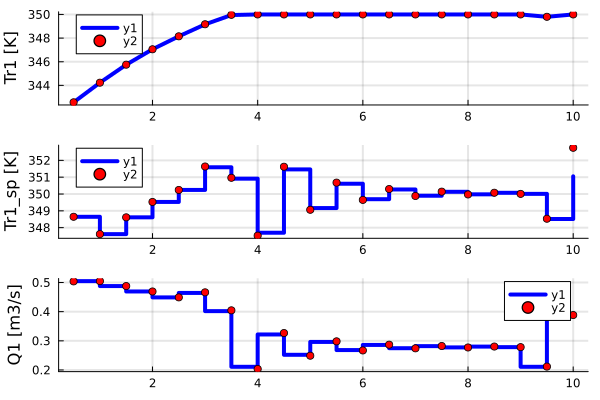

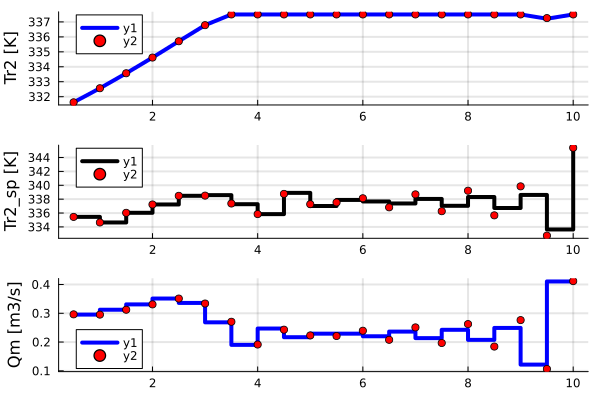

In [45]:
gr() #g11 p20

p24 = plot(t_cldrto,Tr_cldrto_c[1,:],linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Tr1 [K]")
p24 = scatter!(t_cldrto,Tr_cldrto_uc[1,:],marker=:circle,markercolor = :red)

p25 = plot(t_cldrto,yspArray_c[1,:],linewidth=4,linetype=:steppost,linecolor = :blue,gridlinewidth=2,yaxis="Tr1_sp [K]",legend=false)
p25 = scatter!(t_cldrto,yspArray_uc[1,:],marker=:circle,markercolor = :red,legend=false)
p25.series_list[1][:label] = "Unc."
p25.series_list[2][:label] = "Con."

p26 = plot(t_cldrto,Q_cldro_c,linewidth=4,linetype=:steppre,linecolor = :blue,gridlinewidth=2,yaxis="Q1 [m3/s]",legend=false)
p26 = scatter!(t_cldrto,Q_cldro_uc,marker=:circle,markercolor = :red,legend=false)
g13 = plot(p24,p25,p26,layout=(3,1),legend=false)
display(g13)

p27 = plot(t_cldrto,Tr_cldrto_c[2,:],linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Tr2 [K]",legend=false)
p27 = scatter!(t_cldrto,Tr_cldrto_uc[2,:],marker=:circle,markercolor = :red,legend=false)

p28 = plot(t_cldrto,yspArray_c[2,:],linewidth=4,linetype=:steppost,linecolor = :blue,gridlinewidth=2,yaxis="Tr2_sp [K]",legend=false)
p28 = scatter!(t_cldrto,yspArray_uc[2,:],marker=:circle,markercolor = :red,legend=false)

p29 = plot(t_cldrto,Qm_cldrto_c,linewidth=4,linetype=:steppre,linecolor = :blue,gridlinewidth=2,yaxis="Qm [m3/s]",legend=false)
p29 = scatter!(t_cldrto,Qm_cldrto_uc,marker=:circle,markercolor = :red,legend=false)

g14 = plot(p27,p28,p29,layout=(3,1))
display(g14)


In [56]:
display(uMax[2] - uref[2])
display(uMin[2] - uref[2])
display(value.(uMPC[2,19,:]))

0.5733611760541275

-0.17663882394587255

3-element Vector{Float64}:
 -0.10488077292643326
 -0.16080367274341523
 -0.17661343361099477